In [1]:
# 모듈 import
from datetime import datetime
import numpy as np
import os
import pandas as pd
import seaborn as sns

#from google.colab import drive
#drive.mount('/content/gdrive')
#os.chdir('/content/gdrive/MyDrive/python/python_dong/data_axis_transform1')

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

#!pip install torchmetrics
import torchmetrics

#!pip install torchinfo
from torchinfo import summary

import matplotlib.pyplot as plt
import math


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# data path 지정
raw_data_path = './data/stocknet-dataset/price/raw'

if 'stocknet' in raw_data_path:
    tra_date = '2014-01-02'
    val_date = '2015-08-03'
    tes_date = '2015-10-01'
    end_date = '2015-12-31'
elif 'kdd17' in raw_data_path:
    tra_date = '2007-01-03'
    val_date = '2015-01-02'
    tes_date = '2016-01-04'
    end_date = '2016-12-31'
else:
    print('unexpected path: %s' % raw_data_path)

# os.path.isfile : 파일이 있는지 없는 지 체크
# os.path.join(data_path, fname) : 폴더 디렉터리와 fname(stockname.csv) 붙임
fnames = [fname for fname in os.listdir(raw_data_path) if
            os.path.isfile(os.path.join(raw_data_path,fname))]

COLUMNS_FEATURE_DATA_V1 = ['open_close_ratio', 'high_close_ratio', 
                           'low_close_ratio', 'close_lastclose_ratio', 
                           'adjclose_lastadjclose_ratio', 'close_ma5_ratio', 
                           'close_ma10_ratio', 'close_ma15_ratio', 'close_ma20_ratio', 
                           'close_ma25_ratio', 'close_ma30_ratio']

ver = 'v1' # ver in ['v1', 'v2']
if ver == 'v1':
    COLUMNS_FEATURE = COLUMNS_FEATURE_DATA_V1

In [3]:
windows = [5,10,15,20,25,30]

def preprocess(df, windows):
   '''
   전처리 함수 역할 : 전체 feature생성하여 df column에 추가
   '''
   data = df
   data['open_close_ratio'] = data['Open'] / data['Close'] - 1
   data['high_close_ratio'] = data['High'] / data['Close'] - 1
   data['low_close_ratio'] = data['Low'] / data['Close'] - 1

   data['close_lastclose_ratio'] = np.zeros(len(data))
   data.loc[1:, 'close_lastclose_ratio'] = data['Close'][1:].values / data['Close'][:-1].values - 1

   data['adjclose_lastadjclose_ratio'] = np.zeros(len(data))
   data.loc[1:, 'adjclose_lastadjclose_ratio'] = data['Adj Close'][1:].values / data['Adj Close'][:-1].values - 1

   for window in windows:
      data[f'close_ma{window}_ratio'] = data['Adj Close'].rolling(window).mean()/data['Adj Close'] - 1
   
   data['label'] = np.append((data['Close'][1:].values > data['Close'][:-1].values)*1,0)

   return data

In [4]:
feature_data_path = './data/stocknet-dataset/price/feature'

for fname in fnames:
   if not os.path.isfile(os.path.join(feature_data_path,fname)):
      df_raw = pd.read_csv(os.path.join(raw_data_path,fname))
      data = preprocess(df_raw, windows)

      # 폴더 없으면 생성
      try:
         if not os.path.exists(feature_data_path):
            os.makedirs(feature_data_path)
      except OSError:
         print ('Error: Creating directory. ' +  feature_data_path)

      #csv 파일 저장
      data.to_csv(os.path.join(feature_data_path,fname))



In [5]:
raw_data_path = './data/stocknet-dataset/price/raw'


tra_data_X = []
tra_data_Y = []
val_data_X = []
val_data_Y = []
test_data_X = []
test_data_Y = []
tickers = []

cnt = 0
fail_cnt = 0

fnames = [fname for fname in os.listdir(raw_data_path) if
            os.path.isfile(os.path.join(raw_data_path,fname))]

for fname in fnames:

    df = pd.read_csv(os.path.join(raw_data_path,fname))
    data = preprocess(df, windows)

    learning_data = data[(data['Date'] >= tra_date) & (data['Date'] <= end_date)]['Date']
    tra_data_X_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)][COLUMNS_FEATURE]
    tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['adjclose_lastadjclose_ratio']
    #tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['label']

    val_data_X_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)][COLUMNS_FEATURE]
    val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['adjclose_lastadjclose_ratio']
    #val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['label'] 

    test_data_X_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)][COLUMNS_FEATURE]
    test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['adjclose_lastadjclose_ratio']
    #test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['label']


    if cnt == 0:
        # 첫 티커의 learining_data는 학습 date를 갖는 array
        # 첫 티커의 학습 date를 target_dates로 두고, 다음 티커들은 target_dates와 대조
        # 학습 date가 같으면 학습data에 추가, 아니면 추가하지않음
        # 학습 date가 같으면 vali, test date도 같은걸로 가정
        target_dates = learning_data
    
    print('ticker : {}, date check : {}'.format(fname, np.array_equal(target_dates.values, learning_data.values)))
    if np.array_equal(target_dates.values, learning_data.values): 
        
        tra_data_X.append(tra_data_X_ticker.values)
        tra_data_Y.append(tra_data_Y_ticker.values)

        val_data_X.append(val_data_X_ticker.values)
        val_data_Y.append(val_data_Y_ticker.values)
        
        test_data_X.append(test_data_X_ticker.values)
        test_data_Y.append(test_data_Y_ticker.values)

        tickers.append(fname)
    else : 
        fail_cnt += 1
    
    cnt += 1

print(cnt, len(fnames))
print('fail_cnt :', fail_cnt)

'''
# 마지막에 index 종목 넣기
raw_data_index_path = './data/stocknet-dataset/price/raw/index'

fname = os.listdir(raw_data_index_path)[0]

df = pd.read_csv(os.path.join(raw_data_index_path,fname))
data = preprocess(df, windows)

learning_data = data[(data['Date'] >= tra_date) & (data['Date'] <= end_date)]['Date']
tra_data_X_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)][COLUMNS_FEATURE]
tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['adjclose_lastadjclose_ratio']
#tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['label']

val_data_X_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)][COLUMNS_FEATURE]
val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['adjclose_lastadjclose_ratio']
#val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['label']

test_data_X_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)][COLUMNS_FEATURE]
test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['adjclose_lastadjclose_ratio']
#test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['label']

print('ticker : {}, date check : {}'.format(fname, np.array_equal(target_dates.values, learning_data.values)))
if np.array_equal(target_dates.values, learning_data.values):
    
    tra_data_X.append(tra_data_X_ticker.values)
    # tra_data_Y.append(tra_data_Y_ticker.values)

    val_data_X.append(val_data_X_ticker.values)
    # val_data_Y.append(val_data_Y_ticker.values)
    
    test_data_X.append(test_data_X_ticker.values)
    # test_data_Y.append(test_data_Y_ticker.values)

    tickers.append(fname)

# tra_data_X
'''

ticker : AAPL.csv, date check : True
ticker : ABB.csv, date check : True
ticker : ABBV.csv, date check : True
ticker : AEP.csv, date check : True
ticker : AGFS.csv, date check : False
ticker : AMGN.csv, date check : True
ticker : AMZN.csv, date check : True
ticker : BA.csv, date check : True
ticker : BABA.csv, date check : False
ticker : BAC.csv, date check : True
ticker : BBL.csv, date check : True
ticker : BCH.csv, date check : True
ticker : BHP.csv, date check : True
ticker : BP.csv, date check : True
ticker : BRK-A.csv, date check : True
ticker : BSAC.csv, date check : True
ticker : BUD.csv, date check : True
ticker : C.csv, date check : True
ticker : CAT.csv, date check : True
ticker : CELG.csv, date check : True
ticker : CHL.csv, date check : True
ticker : CHTR.csv, date check : True
ticker : CMCSA.csv, date check : True
ticker : CODI.csv, date check : True
ticker : CSCO.csv, date check : True
ticker : CVX.csv, date check : True
ticker : D.csv, date check : True
ticker : DHR.csv,

"\n# 마지막에 index 종목 넣기\nraw_data_index_path = './data/stocknet-dataset/price/raw/index'\n\nfname = os.listdir(raw_data_index_path)[0]\n\ndf = pd.read_csv(os.path.join(raw_data_index_path,fname))\ndata = preprocess(df, windows)\n\nlearning_data = data[(data['Date'] >= tra_date) & (data['Date'] <= end_date)]['Date']\ntra_data_X_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)][COLUMNS_FEATURE]\ntra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['adjclose_lastadjclose_ratio']\n#tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['label']\n\nval_data_X_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)][COLUMNS_FEATURE]\nval_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['adjclose_lastadjclose_ratio']\n#val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['label']\n\ntest_data_X_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= 

In [6]:
tra_data_X_ticker.head().isnull().sum().sum()

0

In [7]:
val_data_X_ticker.head().isnull().sum().sum()

0

In [8]:
test_data_X_ticker.head().isnull().sum().sum()

0

In [9]:
def list_to_tensor(list_):
    return torch.Tensor(np.array(list_))

In [10]:
tensor_tra_data_X = list_to_tensor(tra_data_X)
tensor_tra_data_Y = list_to_tensor(tra_data_Y).view((len(tra_data_Y),-1,1))
tensor_val_data_X = list_to_tensor(val_data_X)
tensor_val_data_Y = list_to_tensor(val_data_Y).view((len(val_data_Y),-1,1))
tensor_test_data_X = list_to_tensor(test_data_X)
tensor_test_data_Y = list_to_tensor(test_data_Y).view((len(test_data_Y),-1,1))

In [22]:
from torch.autograd import Variable

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F


class Encoder(nn.Module):
    """encoder in DA_RNN."""

    def __init__(self, T,
                 input_size,
                 encoder_num_hidden,
                 parallel=False):
        """Initialize an encoder in DA_RNN."""
        super(Encoder, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.input_size = input_size
        self.parallel = parallel
        self.T = T

        # Fig 1. Temporal Attention Mechanism: Encoder is LSTM
        self.encoder_lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.encoder_num_hidden,
            num_layers = 1
        )

        # Construct Input Attention Mechanism via deterministic attention model
        # Eq. 8: W_e[h_{t-1}; s_{t-1}] + U_e * x^k
        self.encoder_attn = nn.Linear(
            in_features=2 * self.encoder_num_hidden + self.T - 1,
            out_features=1
        )

    def forward(self, X):
        """forward.

        Args:
            X: input data

        """
        X_tilde = Variable(X.data.new(
            X.size(0), self.T - 1, self.input_size).zero_())
        X_encoded = Variable(X.data.new(
            X.size(0), self.T - 1, self.encoder_num_hidden).zero_())

        # Eq. 8, parameters not in nn.Linear but to be learnt
        # v_e = torch.nn.Parameter(data=torch.empty(
        #     self.input_size, self.T).uniform_(0, 1), requires_grad=True)
        # U_e = torch.nn.Parameter(data=torch.empty(
        #     self.T, self.T).uniform_(0, 1), requires_grad=True)

        # h_n, s_n: initial states with dimention hidden_size
        h_n = self._init_states(X)
        s_n = self._init_states(X)

        for t in range(self.T - 1):
            # batch_size * input_size * (2 * hidden_size + T - 1)
            x = torch.cat((h_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           s_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           X.permute(0, 2, 1)), dim=2)

            x = self.encoder_attn(
                x.view(-1, self.encoder_num_hidden * 2 + self.T - 1))

            # get weights by softmax
            alpha = F.softmax(x.view(-1, self.input_size))

            # get new input for LSTM
            x_tilde = torch.mul(alpha, X[:, t, :])

            # Fix the warning about non-contiguous memory
            # https://discuss.pytorch.org/t/dataparallel-issue-with-flatten-parameter/8282
            self.encoder_lstm.flatten_parameters()

            # encoder LSTM
            _, final_state = self.encoder_lstm(x_tilde.unsqueeze(0), (h_n, s_n))
            h_n = final_state[0]
            s_n = final_state[1]

            X_tilde[:, t, :] = x_tilde
            X_encoded[:, t, :] = h_n

        return X_tilde, X_encoded

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X

        Returns:
            initial_hidden_states
        """
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.encoder_num_hidden).zero_())


class Decoder(nn.Module):
    """decoder in DA_RNN."""

    def __init__(self, T, decoder_num_hidden, encoder_num_hidden):
        """Initialize a decoder in DA_RNN."""
        super(Decoder, self).__init__()
        self.decoder_num_hidden = decoder_num_hidden
        self.encoder_num_hidden = encoder_num_hidden
        self.T = T

        self.attn_layer = nn.Sequential(
            nn.Linear(2 * decoder_num_hidden + encoder_num_hidden, encoder_num_hidden),
            nn.Tanh(),
            nn.Linear(encoder_num_hidden, 1)
        )
        self.lstm_layer = nn.LSTM(
            input_size=1,
            hidden_size=decoder_num_hidden
        )
        self.fc = nn.Linear(encoder_num_hidden + 1, 1)
        self.fc_final = nn.Linear(decoder_num_hidden + encoder_num_hidden, 1)

        self.fc.weight.data.normal_()

    def forward(self, X_encoded, y_prev):
        """forward."""
        d_n = self._init_states(X_encoded)
        c_n = self._init_states(X_encoded)

        for t in range(self.T - 1):

            x = torch.cat((d_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           c_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           X_encoded), dim=2)

            beta = F.softmax(self.attn_layer(
                x.view(-1, 2 * self.decoder_num_hidden + self.encoder_num_hidden)).view(-1, self.T - 1))

            # Eqn. 14: compute context vector
            # batch_size * encoder_hidden_size
            context = torch.bmm(beta.unsqueeze(1), X_encoded)[:, 0, :]
            if t < self.T - 1:
                # Eqn. 15
                # batch_size * 1
                y_tilde = self.fc(
                    torch.cat((context, y_prev[:, t].unsqueeze(1)), dim=1))

                # Eqn. 16: LSTM
                self.lstm_layer.flatten_parameters()
                _, final_states = self.lstm_layer(
                    y_tilde.unsqueeze(0), (d_n, c_n))

                d_n = final_states[0]  # 1 * batch_size * decoder_num_hidden
                c_n = final_states[1]  # 1 * batch_size * decoder_num_hidden

        # Eqn. 22: final output
        y_pred = self.fc_final(torch.cat((d_n[0], context), dim=1))

        return y_pred

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X
        Returns:
            initial_hidden_states

        """
        # hidden state and cell state [num_layers*num_directions, batch_size, hidden_size]
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.decoder_num_hidden).zero_())


class DA_rnn(nn.Module):
    """da_rnn."""

    def __init__(self, X, y, T,
                 encoder_num_hidden,
                 decoder_num_hidden,
                 batch_size,
                 learning_rate,
                 epochs,
                 parallel=False):
        """da_rnn initialization."""
        super(DA_rnn, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.decoder_num_hidden = decoder_num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.parallel = parallel
        self.shuffle = False
        self.epochs = epochs
        self.T = T
        self.X = X
        self.y = y

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print("==> Use accelerator: ", self.device)

        self.Encoder = Encoder(input_size=X.shape[1],
                               encoder_num_hidden=encoder_num_hidden,
                               T=T).to(self.device)
        self.Decoder = Decoder(encoder_num_hidden=encoder_num_hidden,
                               decoder_num_hidden=decoder_num_hidden,
                               T=T).to(self.device)

        # Loss function
        self.criterion = nn.MSELoss()

        if self.parallel:
            self.encoder = nn.DataParallel(self.encoder)
            self.decoder = nn.DataParallel(self.decoder)

        self.encoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Encoder.parameters()),
                                            lr=self.learning_rate)
        self.decoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Decoder.parameters()),
                                            lr=self.learning_rate)

        # Training set
        self.train_timesteps = int(self.X.shape[0] * 0.7)
        self.y = self.y - np.mean(self.y[:self.train_timesteps])
        self.input_size = self.X.shape[1]

    def train(self):
        """training process."""
        iter_per_epoch = int(np.ceil(self.train_timesteps * 1. / self.batch_size))
        self.iter_losses = np.zeros(self.epochs * iter_per_epoch)
        self.epoch_losses = np.zeros(self.epochs)

        n_iter = 0

        for epoch in range(self.epochs):
            if self.shuffle:
                ref_idx = np.random.permutation(self.train_timesteps - self.T)
            else:
                ref_idx = np.array(range(self.train_timesteps - self.T))

            idx = 0

            while (idx < self.train_timesteps):
                # get the indices of X_train
                indices = ref_idx[idx:(idx + self.batch_size)]
                # x = np.zeros((self.T - 1, len(indices), self.input_size))
                x = np.zeros((len(indices), self.T - 1, self.input_size))
                y_prev = np.zeros((len(indices), self.T - 1))
                y_gt = self.y[indices + self.T]

                # format x into 3D tensor
                for bs in range(len(indices)):
                    x[bs, :, :] = self.X[indices[bs]:(indices[bs] + self.T - 1), :]
                    y_prev[bs, :] = self.y[indices[bs]: (indices[bs] + self.T - 1)]

                loss = self.train_forward(x, y_prev, y_gt)
                self.iter_losses[int(epoch * iter_per_epoch + idx / self.batch_size)] = loss

                idx += self.batch_size
                n_iter += 1

                if n_iter % 10000 == 0 and n_iter != 0:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9

                self.epoch_losses[epoch] = np.mean(self.iter_losses[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])

            if epoch % 10 == 0:
                print("Epochs: ", epoch, " Iterations: ", n_iter,
                      " Loss: ", self.epoch_losses[epoch])

            if epoch % 100 == 0:
                y_train_pred = self.test(on_train=True)
                y_test_pred = self.test(on_train=False)
                y_pred = np.concatenate((y_train_pred, y_test_pred))
                plt.ioff()
                plt.figure()
                plt.plot(range(1, 1 + len(self.y)), self.y, label="True")
                plt.plot(range(self.T, len(y_train_pred) + self.T),
                         y_train_pred, label='Predicted - Train')
                plt.plot(range(self.T + len(y_train_pred), len(self.y) + 1),
                         y_test_pred, label='Predicted - Test')
                plt.legend(loc='upper left')
                plt.show()

            # # Save files in last iterations
            # if epoch == self.epochs - 1:
            #     np.savetxt('../loss.txt', np.array(self.epoch_losses), delimiter=',')
            #     np.savetxt('../y_pred.txt',
            #                np.array(self.y_pred), delimiter=',')
            #     np.savetxt('../y_true.txt',
            #                np.array(self.y_true), delimiter=',')

    def train_forward(self, X, y_prev, y_gt):
        """
        Forward pass.

        Args:
            X:
            y_prev:
            y_gt: Ground truth label

        """
        # zero gradients
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        input_weighted, input_encoded = self.Encoder(
            Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
        y_pred = self.Decoder(input_encoded, Variable(
            torch.from_numpy(y_prev).type(torch.FloatTensor).to(self.device)))

        y_true = Variable(torch.from_numpy(
            y_gt).type(torch.FloatTensor).to(self.device))

        y_true = y_true.view(-1, 1)
        loss = self.criterion(y_pred, y_true)
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return loss.item()


    def test(self, on_train=False):
        """test."""

        if on_train:
            y_pred = np.zeros(self.train_timesteps - self.T + 1)
        else:
            y_pred = np.zeros(self.X.shape[0] - self.train_timesteps)

        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i: (i + self.batch_size)]
            X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
            y_history = np.zeros((len(batch_idx), self.T - 1))

            for j in range(len(batch_idx)):
                if on_train:
                    X[j, :, :] = self.X[range(
                        batch_idx[j], batch_idx[j] + self.T - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j], batch_idx[j] + self.T - 1)]
                else:
                    X[j, :, :] = self.X[range(
                        batch_idx[j] + self.train_timesteps - self.T, batch_idx[j] + self.train_timesteps - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j] + self.train_timesteps - self.T, batch_idx[j] + self.train_timesteps - 1)]

            y_history = Variable(torch.from_numpy(
                y_history).type(torch.FloatTensor).to(self.device))
            _, input_encoded = self.Encoder(
                Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
            y_pred[i:(i + self.batch_size)] = self.Decoder(input_encoded,
                                                           y_history).cpu().data.numpy()[:, 0]
            i += self.batch_size

        return y_pred

In [23]:
ticker_idx = 0

In [24]:
X = tra_data_X[ticker_idx]
y = tra_data_Y[ticker_idx]

In [25]:
#X = sample_x
#y = sample_y

batchsize = 128
nhidden_encoder = 128
nhidden_decoder = 128
ntimestep = 10
lr = 0.001
epochs = 10000

==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  3  Loss:  0.003979610337410122


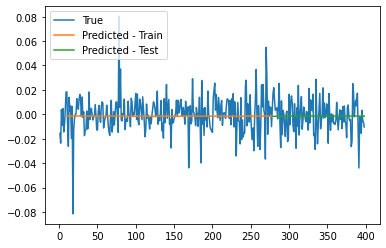

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  10  Iterations:  33  Loss:  0.0002946851503414412
Epochs:  20  Iterations:  63  Loss:  0.0002933124827298646
Epochs:  30  Iterations:  93  Loss:  0.00029107283141153556
Epochs:  40  Iterations:  123  Loss:  0.0002905999232704441
Epochs:  50  Iterations:  153  Loss:  0.00029050100905199844
Epochs:  60  Iterations:  183  Loss:  0.00029042189513954025
Epochs:  70  Iterations:  213  Loss:  0.00029034664718589437
Epochs:  80  Iterations:  243  Loss:  0.00029028136244354147
Epochs:  90  Iterations:  273  Loss:  0.0002902255704005559
Epochs:  100  Iterations:  303  Loss:  0.0002901783639875551


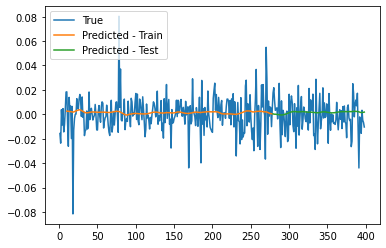

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  110  Iterations:  333  Loss:  0.00029013970925007015
Epochs:  120  Iterations:  363  Loss:  0.0002901086797161649
Epochs:  130  Iterations:  393  Loss:  0.00029008411123262096
Epochs:  140  Iterations:  423  Loss:  0.00029006446614706266
Epochs:  150  Iterations:  453  Loss:  0.0002900481825539221
Epochs:  160  Iterations:  483  Loss:  0.0002900338440667838
Epochs:  170  Iterations:  513  Loss:  0.00029002012161072344
Epochs:  180  Iterations:  543  Loss:  0.000290006054759336
Epochs:  190  Iterations:  573  Loss:  0.00028999067823557806
Epochs:  200  Iterations:  603  Loss:  0.0002899735700339079


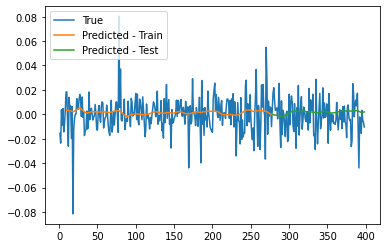

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  210  Iterations:  633  Loss:  0.00028995403651303303
Epochs:  220  Iterations:  663  Loss:  0.00028993187394614023
Epochs:  230  Iterations:  693  Loss:  0.00028990672338598716
Epochs:  240  Iterations:  723  Loss:  0.00028987834715129185
Epochs:  250  Iterations:  753  Loss:  0.000289846517262049
Epochs:  260  Iterations:  783  Loss:  0.0002898109960369766
Epochs:  270  Iterations:  813  Loss:  0.00028977165250883746
Epochs:  280  Iterations:  843  Loss:  0.00028972818593805033
Epochs:  290  Iterations:  873  Loss:  0.00028968028103311855
Epochs:  300  Iterations:  903  Loss:  0.00028962780197616667


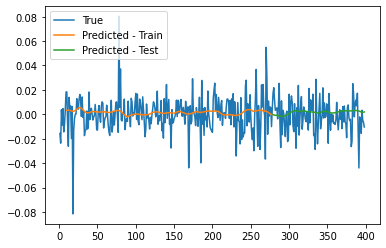

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  310  Iterations:  933  Loss:  0.0002895704043718676
Epochs:  320  Iterations:  963  Loss:  0.0002895077923312783
Epochs:  330  Iterations:  993  Loss:  0.0002894395972058798
Epochs:  340  Iterations:  1023  Loss:  0.0002893655910156667
Epochs:  350  Iterations:  1053  Loss:  0.0002892853372031823
Epochs:  360  Iterations:  1083  Loss:  0.000289198510775653
Epochs:  370  Iterations:  1113  Loss:  0.00028910459756540757
Epochs:  380  Iterations:  1143  Loss:  0.0002890033113847797
Epochs:  390  Iterations:  1173  Loss:  0.0002888942350788663
Epochs:  400  Iterations:  1203  Loss:  0.0002887768011229734


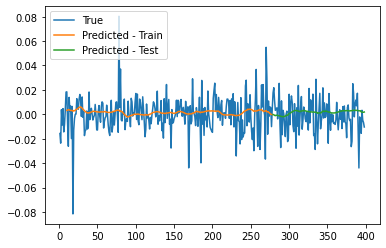

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  410  Iterations:  1233  Loss:  0.00028865054870645207
Epochs:  420  Iterations:  1263  Loss:  0.00028851490545397
Epochs:  430  Iterations:  1293  Loss:  0.00028836936689913273
Epochs:  440  Iterations:  1323  Loss:  0.0002882132782057549
Epochs:  450  Iterations:  1353  Loss:  0.0002880458584210525
Epochs:  460  Iterations:  1383  Loss:  0.0002878664672607556
Epochs:  470  Iterations:  1413  Loss:  0.0002876741685516511
Epochs:  480  Iterations:  1443  Loss:  0.00028746796306222677
Epochs:  490  Iterations:  1473  Loss:  0.0002872468806648006
Epochs:  500  Iterations:  1503  Loss:  0.0002870095389274259


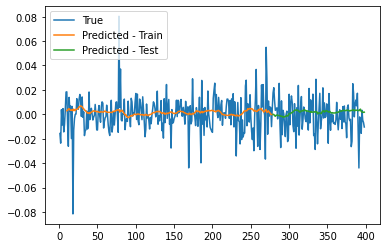

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  510  Iterations:  1533  Loss:  0.0002867546087751786
Epochs:  520  Iterations:  1563  Loss:  0.00028648039248461526
Epochs:  530  Iterations:  1593  Loss:  0.00028618504681314033
Epochs:  540  Iterations:  1623  Loss:  0.0002858664180773
Epochs:  550  Iterations:  1653  Loss:  0.00028552176081575453
Epochs:  560  Iterations:  1683  Loss:  0.00028514845568376285
Epochs:  570  Iterations:  1713  Loss:  0.0002847428841050714
Epochs:  580  Iterations:  1743  Loss:  0.0002843012965361898
Epochs:  590  Iterations:  1773  Loss:  0.00028381956993446994
Epochs:  600  Iterations:  1803  Loss:  0.0002832932077581063


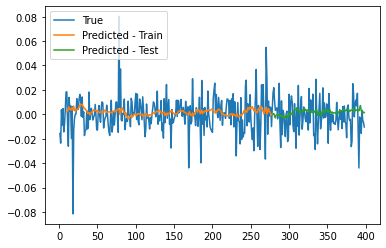

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  610  Iterations:  1833  Loss:  0.00028271837800275534
Epochs:  620  Iterations:  1863  Loss:  0.0002820922090904787
Epochs:  630  Iterations:  1893  Loss:  0.0002814141820029666
Epochs:  640  Iterations:  1923  Loss:  0.0002806872022726263
Epochs:  650  Iterations:  1953  Loss:  0.00027991822086429846
Epochs:  660  Iterations:  1983  Loss:  0.00027911677898373455
Epochs:  670  Iterations:  2013  Loss:  0.000278291695091563
Epochs:  680  Iterations:  2043  Loss:  0.00027744497735208523
Epochs:  690  Iterations:  2073  Loss:  0.0002765665315867712
Epochs:  700  Iterations:  2103  Loss:  0.0002756298442060749


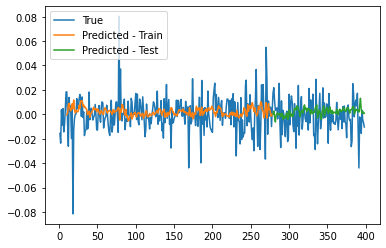

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  710  Iterations:  2133  Loss:  0.0002745848469203338
Epochs:  720  Iterations:  2163  Loss:  0.0002733328292379156
Epochs:  730  Iterations:  2193  Loss:  0.00027163722067295265
Epochs:  740  Iterations:  2223  Loss:  0.0002688313106773421
Epochs:  750  Iterations:  2253  Loss:  0.00026698687482470024
Epochs:  760  Iterations:  2283  Loss:  0.00026047107530757785
Epochs:  770  Iterations:  2313  Loss:  0.00025531916859714937
Epochs:  780  Iterations:  2343  Loss:  0.00025068517425097525
Epochs:  790  Iterations:  2373  Loss:  0.00024512436842390645
Epochs:  800  Iterations:  2403  Loss:  0.00024465280390965444


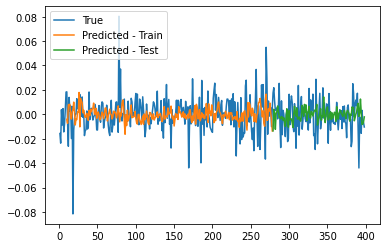

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  810  Iterations:  2433  Loss:  0.00023900191687668362
Epochs:  820  Iterations:  2463  Loss:  0.0002344987685016046
Epochs:  830  Iterations:  2493  Loss:  0.0002381441299803555
Epochs:  840  Iterations:  2523  Loss:  0.0002390551041268433
Epochs:  850  Iterations:  2553  Loss:  0.00023250587886044136
Epochs:  860  Iterations:  2583  Loss:  0.00023274560226127505
Epochs:  870  Iterations:  2613  Loss:  0.00022348416678141803
Epochs:  880  Iterations:  2643  Loss:  0.00022706468007527292
Epochs:  890  Iterations:  2673  Loss:  0.0002198277118926247
Epochs:  900  Iterations:  2703  Loss:  0.00022340054177523902


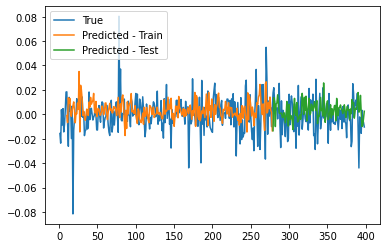

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  910  Iterations:  2733  Loss:  0.00022517411950199553
Epochs:  920  Iterations:  2763  Loss:  0.00023817820571518192
Epochs:  930  Iterations:  2793  Loss:  0.00022031775248857835
Epochs:  940  Iterations:  2823  Loss:  0.00022286664655742547
Epochs:  950  Iterations:  2853  Loss:  0.00021729247722153863
Epochs:  960  Iterations:  2883  Loss:  0.00020499810246595493
Epochs:  970  Iterations:  2913  Loss:  0.0002071503937865297
Epochs:  980  Iterations:  2943  Loss:  0.0002162339175508047
Epochs:  990  Iterations:  2973  Loss:  0.00019985239972205213
Epochs:  1000  Iterations:  3003  Loss:  0.00020644869073294103


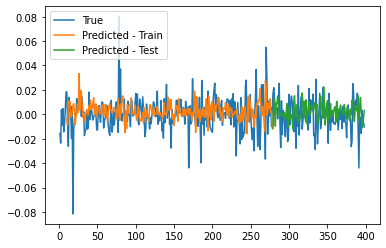

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  1010  Iterations:  3033  Loss:  0.00019943516235798597
Epochs:  1020  Iterations:  3063  Loss:  0.00020115576626267284
Epochs:  1030  Iterations:  3093  Loss:  0.00020166892500128597
Epochs:  1040  Iterations:  3123  Loss:  0.00019394302701887986
Epochs:  1050  Iterations:  3153  Loss:  0.00019592419266700745
Epochs:  1060  Iterations:  3183  Loss:  0.00020637183236734322
Epochs:  1070  Iterations:  3213  Loss:  0.0001934838292072527
Epochs:  1080  Iterations:  3243  Loss:  0.00020317627543893954
Epochs:  1090  Iterations:  3273  Loss:  0.0001981741030855725
Epochs:  1100  Iterations:  3303  Loss:  0.00019862744860195866


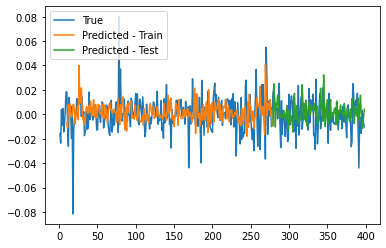

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  1110  Iterations:  3333  Loss:  0.00020127305469941348
Epochs:  1120  Iterations:  3363  Loss:  0.00018722500196114802
Epochs:  1130  Iterations:  3393  Loss:  0.00019064823087925711
Epochs:  1140  Iterations:  3423  Loss:  0.00018657103889078522
Epochs:  1150  Iterations:  3453  Loss:  0.00018629045856262869
Epochs:  1160  Iterations:  3483  Loss:  0.0001821987025323324
Epochs:  1170  Iterations:  3513  Loss:  0.00018234020293069383
Epochs:  1180  Iterations:  3543  Loss:  0.00018547710351413116
Epochs:  1190  Iterations:  3573  Loss:  0.00018586644485670453
Epochs:  1200  Iterations:  3603  Loss:  0.0001895261108681249


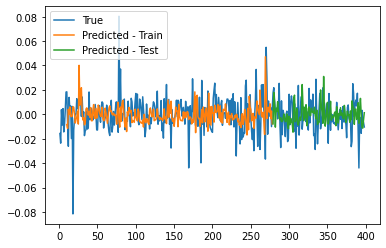

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  1210  Iterations:  3633  Loss:  0.0001776369390427135
Epochs:  1220  Iterations:  3663  Loss:  0.00017627822671784088
Epochs:  1230  Iterations:  3693  Loss:  0.0001811505547569444
Epochs:  1240  Iterations:  3723  Loss:  0.00018265725520905107
Epochs:  1250  Iterations:  3753  Loss:  0.00017909160912192115
Epochs:  1260  Iterations:  3783  Loss:  0.0001723044648921738
Epochs:  1270  Iterations:  3813  Loss:  0.00017313597830555713
Epochs:  1280  Iterations:  3843  Loss:  0.00017948772680635253
Epochs:  1290  Iterations:  3873  Loss:  0.00016978459704356888
Epochs:  1300  Iterations:  3903  Loss:  0.00018056213593808934


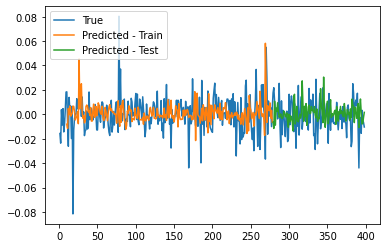

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  1310  Iterations:  3933  Loss:  0.0001799122085988832
Epochs:  1320  Iterations:  3963  Loss:  0.00017951385719546428
Epochs:  1330  Iterations:  3993  Loss:  0.00017030541494023055
Epochs:  1340  Iterations:  4023  Loss:  0.00016968634736258537
Epochs:  1350  Iterations:  4053  Loss:  0.0001733888263212672
Epochs:  1360  Iterations:  4083  Loss:  0.00018395332396418476
Epochs:  1370  Iterations:  4113  Loss:  0.000167628655617591
Epochs:  1380  Iterations:  4143  Loss:  0.00017961676106400168
Epochs:  1390  Iterations:  4173  Loss:  0.0001621657150584118
Epochs:  1400  Iterations:  4203  Loss:  0.00016229898513605198


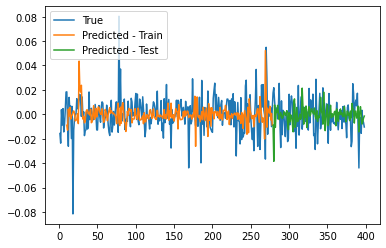

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  1410  Iterations:  4233  Loss:  0.00016707663356404132
Epochs:  1420  Iterations:  4263  Loss:  0.0001737817656248808
Epochs:  1430  Iterations:  4293  Loss:  0.00015998130159763
Epochs:  1440  Iterations:  4323  Loss:  0.00016934547238633968
Epochs:  1450  Iterations:  4353  Loss:  0.00015974085908965208
Epochs:  1460  Iterations:  4383  Loss:  0.00015867469604321135
Epochs:  1470  Iterations:  4413  Loss:  0.00015237670959322713
Epochs:  1480  Iterations:  4443  Loss:  0.00015073905524332076
Epochs:  1490  Iterations:  4473  Loss:  0.0001559344285245364
Epochs:  1500  Iterations:  4503  Loss:  0.00014885780365148094


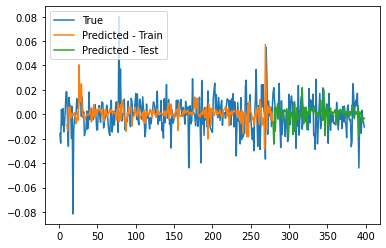

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  1510  Iterations:  4533  Loss:  0.00014638762513641268
Epochs:  1520  Iterations:  4563  Loss:  0.00016302270645004077
Epochs:  1530  Iterations:  4593  Loss:  0.00014535752476755684
Epochs:  1540  Iterations:  4623  Loss:  0.0001480982591601787
Epochs:  1550  Iterations:  4653  Loss:  0.00015450454823925006
Epochs:  1560  Iterations:  4683  Loss:  0.00014295677040839413
Epochs:  1570  Iterations:  4713  Loss:  0.00015513729219189068
Epochs:  1580  Iterations:  4743  Loss:  0.0001433199601403127
Epochs:  1590  Iterations:  4773  Loss:  0.000145328159002626
Epochs:  1600  Iterations:  4803  Loss:  0.00014088680533556422


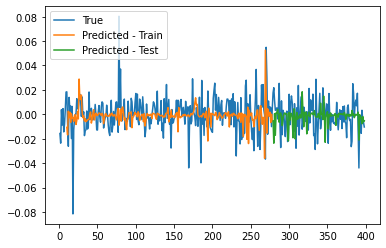

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  1610  Iterations:  4833  Loss:  0.00014365311835717876
Epochs:  1620  Iterations:  4863  Loss:  0.00014010365157446358
Epochs:  1630  Iterations:  4893  Loss:  0.00013942608196278647
Epochs:  1640  Iterations:  4923  Loss:  0.0001384031438647071
Epochs:  1650  Iterations:  4953  Loss:  0.00014213911526894663
Epochs:  1660  Iterations:  4983  Loss:  0.0001454833891330054
Epochs:  1670  Iterations:  5013  Loss:  0.00014942057714506518
Epochs:  1680  Iterations:  5043  Loss:  0.00022032580939897647
Epochs:  1690  Iterations:  5073  Loss:  0.000172432303467455
Epochs:  1700  Iterations:  5103  Loss:  0.00016117956935583302


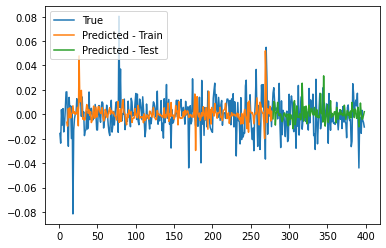

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  1710  Iterations:  5133  Loss:  0.00014916853736698007
Epochs:  1720  Iterations:  5163  Loss:  0.00014094500147621147
Epochs:  1730  Iterations:  5193  Loss:  0.0002962768776342273
Epochs:  1740  Iterations:  5223  Loss:  0.00019091181214510775
Epochs:  1750  Iterations:  5253  Loss:  0.0001685735357265609
Epochs:  1760  Iterations:  5283  Loss:  0.00016056645836215466
Epochs:  1770  Iterations:  5313  Loss:  0.0001527765161881689
Epochs:  1780  Iterations:  5343  Loss:  0.00014680549611512106
Epochs:  1790  Iterations:  5373  Loss:  0.0002229904008951659
Epochs:  1800  Iterations:  5403  Loss:  0.00018534542565854886


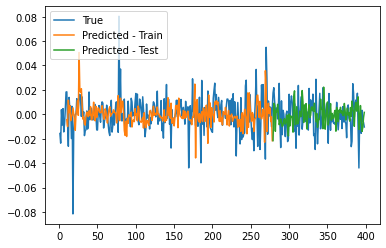

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  1810  Iterations:  5433  Loss:  0.0001772385488341873
Epochs:  1820  Iterations:  5463  Loss:  0.00017234001764639592
Epochs:  1830  Iterations:  5493  Loss:  0.0001675250847862723
Epochs:  1840  Iterations:  5523  Loss:  0.00016311508200791044
Epochs:  1850  Iterations:  5553  Loss:  0.00015913907433665978
Epochs:  1860  Iterations:  5583  Loss:  0.00015553520764418258
Epochs:  1870  Iterations:  5613  Loss:  0.00015138937427157847
Epochs:  1880  Iterations:  5643  Loss:  0.00014289528917288408
Epochs:  1890  Iterations:  5673  Loss:  0.0004513105474567662
Epochs:  1900  Iterations:  5703  Loss:  0.00020501694234553725


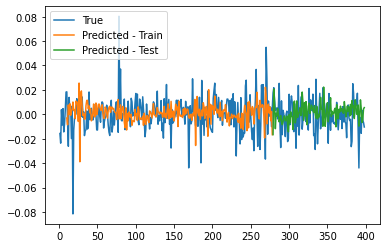

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  1910  Iterations:  5733  Loss:  0.0001958044983136157
Epochs:  1920  Iterations:  5763  Loss:  0.00019434137114634117
Epochs:  1930  Iterations:  5793  Loss:  0.00018969380956453583
Epochs:  1940  Iterations:  5823  Loss:  0.00018657925587225085
Epochs:  1950  Iterations:  5853  Loss:  0.00018418734786488736
Epochs:  1960  Iterations:  5883  Loss:  0.00018203005553611243
Epochs:  1970  Iterations:  5913  Loss:  0.00017995018182167163
Epochs:  1980  Iterations:  5943  Loss:  0.00017789623962016776
Epochs:  1990  Iterations:  5973  Loss:  0.00017587183538125828
Epochs:  2000  Iterations:  6003  Loss:  0.00017390584253007546


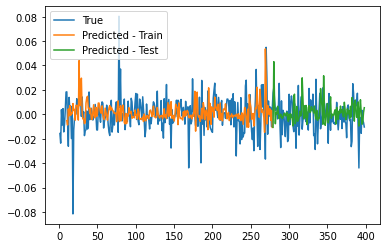

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  2010  Iterations:  6033  Loss:  0.00017203387930445993
Epochs:  2020  Iterations:  6063  Loss:  0.00017028095559605086
Epochs:  2030  Iterations:  6093  Loss:  0.00016865219367900863
Epochs:  2040  Iterations:  6123  Loss:  0.00016713711859968802
Epochs:  2050  Iterations:  6153  Loss:  0.00016571972810197622
Epochs:  2060  Iterations:  6183  Loss:  0.00016438081850841021
Epochs:  2070  Iterations:  6213  Loss:  0.00016309949326872206
Epochs:  2080  Iterations:  6243  Loss:  0.00016185372927187322
Epochs:  2090  Iterations:  6273  Loss:  0.0001606072146387305
Epochs:  2100  Iterations:  6303  Loss:  0.00015927444110275246


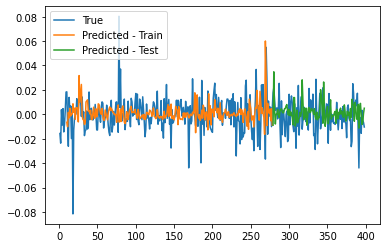

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  2110  Iterations:  6333  Loss:  0.00015785981668159366
Epochs:  2120  Iterations:  6363  Loss:  0.00015649595782936862
Epochs:  2130  Iterations:  6393  Loss:  0.00015519445757187592
Epochs:  2140  Iterations:  6423  Loss:  0.00015381534588717236
Epochs:  2150  Iterations:  6453  Loss:  0.0001524546678410843
Epochs:  2160  Iterations:  6483  Loss:  0.00015235692383915497
Epochs:  2170  Iterations:  6513  Loss:  0.00015012549920356832
Epochs:  2180  Iterations:  6543  Loss:  0.00022296764169974873
Epochs:  2190  Iterations:  6573  Loss:  0.00019811629560232782
Epochs:  2200  Iterations:  6603  Loss:  0.0001676691354077775


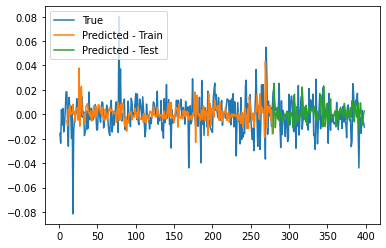

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  2210  Iterations:  6633  Loss:  0.0001572062380243248
Epochs:  2220  Iterations:  6663  Loss:  0.00015588444633370577
Epochs:  2230  Iterations:  6693  Loss:  0.00015430930943693966
Epochs:  2240  Iterations:  6723  Loss:  0.000152893028522764
Epochs:  2250  Iterations:  6753  Loss:  0.00015159697917018397
Epochs:  2260  Iterations:  6783  Loss:  0.00015034666406184746
Epochs:  2270  Iterations:  6813  Loss:  0.0001490188587922603
Epochs:  2280  Iterations:  6843  Loss:  0.00014748899896706766
Epochs:  2290  Iterations:  6873  Loss:  0.000146660176445342
Epochs:  2300  Iterations:  6903  Loss:  0.0001696627671966174


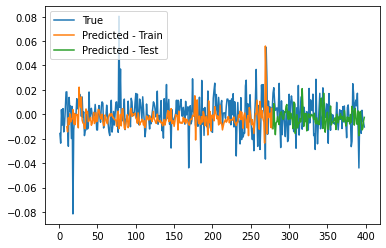

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  2310  Iterations:  6933  Loss:  0.00016021940003459653
Epochs:  2320  Iterations:  6963  Loss:  0.00014883099599198127
Epochs:  2330  Iterations:  6993  Loss:  0.0001485397339517173
Epochs:  2340  Iterations:  7023  Loss:  0.0001578910402410353
Epochs:  2350  Iterations:  7053  Loss:  0.0001944609078539846
Epochs:  2360  Iterations:  7083  Loss:  0.00026092439657077193
Epochs:  2370  Iterations:  7113  Loss:  0.00017922001037125787
Epochs:  2380  Iterations:  7143  Loss:  0.00015466012822192474
Epochs:  2390  Iterations:  7173  Loss:  0.00015589561250332432
Epochs:  2400  Iterations:  7203  Loss:  0.0001546737488145785


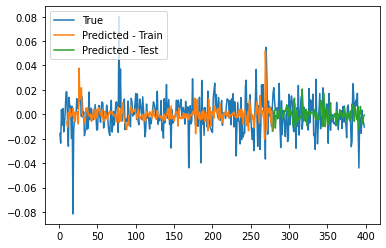

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  2410  Iterations:  7233  Loss:  0.00015355882230020748
Epochs:  2420  Iterations:  7263  Loss:  0.00015286250102993412
Epochs:  2430  Iterations:  7293  Loss:  0.00015182361554858895
Epochs:  2440  Iterations:  7323  Loss:  0.000151972189390411
Epochs:  2450  Iterations:  7353  Loss:  0.00015046576663735323
Epochs:  2460  Iterations:  7383  Loss:  0.00015174891571708335
Epochs:  2470  Iterations:  7413  Loss:  0.0001495975254025931
Epochs:  2480  Iterations:  7443  Loss:  0.0001526079371008867
Epochs:  2490  Iterations:  7473  Loss:  0.00015032105754168393
Epochs:  2500  Iterations:  7503  Loss:  0.00015590453404001892


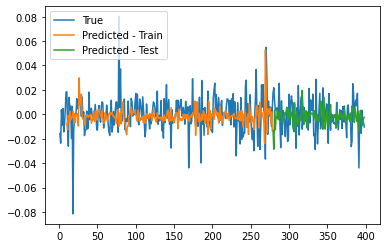

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  2510  Iterations:  7533  Loss:  0.00015703951915687261
Epochs:  2520  Iterations:  7563  Loss:  0.00016573342630484453
Epochs:  2530  Iterations:  7593  Loss:  0.00015294352124328725
Epochs:  2540  Iterations:  7623  Loss:  0.0001421255637978902
Epochs:  2550  Iterations:  7653  Loss:  0.0001504386697585384
Epochs:  2560  Iterations:  7683  Loss:  0.00014124933113635052
Epochs:  2570  Iterations:  7713  Loss:  0.00015005211146975247
Epochs:  2580  Iterations:  7743  Loss:  0.0001394356992629279
Epochs:  2590  Iterations:  7773  Loss:  0.0001521992902174437
Epochs:  2600  Iterations:  7803  Loss:  0.0001483592107736816


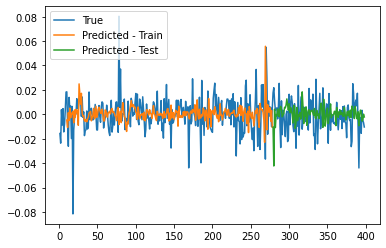

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  2610  Iterations:  7833  Loss:  0.00014340892691204013
Epochs:  2620  Iterations:  7863  Loss:  0.00014498463497147895
Epochs:  2630  Iterations:  7893  Loss:  0.00014877466916611107
Epochs:  2640  Iterations:  7923  Loss:  0.00014438603466260247
Epochs:  2650  Iterations:  7953  Loss:  0.00015266631332148486
Epochs:  2660  Iterations:  7983  Loss:  0.00013955658444804916
Epochs:  2670  Iterations:  8013  Loss:  0.0001553104375489056
Epochs:  2680  Iterations:  8043  Loss:  0.00014324245057650842
Epochs:  2690  Iterations:  8073  Loss:  0.00013706851738485662
Epochs:  2700  Iterations:  8103  Loss:  0.00018441883730702102


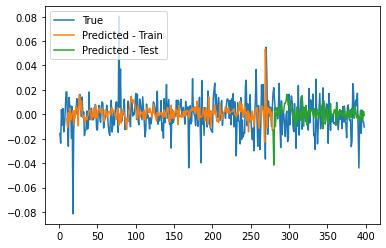

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  2710  Iterations:  8133  Loss:  0.0001437591236026492
Epochs:  2720  Iterations:  8163  Loss:  0.00014887540722459866
Epochs:  2730  Iterations:  8193  Loss:  0.00015462621377082542
Epochs:  2740  Iterations:  8223  Loss:  0.0001410060691947971
Epochs:  2750  Iterations:  8253  Loss:  0.00014140094936010428
Epochs:  2760  Iterations:  8283  Loss:  0.0001355526577147733
Epochs:  2770  Iterations:  8313  Loss:  0.00015161858633897887
Epochs:  2780  Iterations:  8343  Loss:  0.0001398987739473038
Epochs:  2790  Iterations:  8373  Loss:  0.00014310862752608955
Epochs:  2800  Iterations:  8403  Loss:  0.0001443445410889884


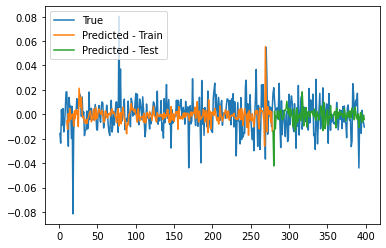

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  2810  Iterations:  8433  Loss:  0.00014234786370555716
Epochs:  2820  Iterations:  8463  Loss:  0.00015056837704226686
Epochs:  2830  Iterations:  8493  Loss:  0.00013676543979575703
Epochs:  2840  Iterations:  8523  Loss:  0.00014021746028447524
Epochs:  2850  Iterations:  8553  Loss:  0.00013646301583018308
Epochs:  2860  Iterations:  8583  Loss:  0.000138031688038609
Epochs:  2870  Iterations:  8613  Loss:  0.0001603239458442355
Epochs:  2880  Iterations:  8643  Loss:  0.00013930613143505374
Epochs:  2890  Iterations:  8673  Loss:  0.00013617674812849145
Epochs:  2900  Iterations:  8703  Loss:  0.0001387432015083808


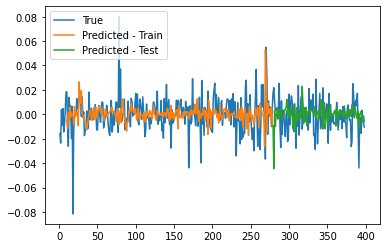

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  2910  Iterations:  8733  Loss:  0.0001587338168368054
Epochs:  2920  Iterations:  8763  Loss:  0.00014528151465735087
Epochs:  2930  Iterations:  8793  Loss:  0.00013619002553847773
Epochs:  2940  Iterations:  8823  Loss:  0.00013745556983243054
Epochs:  2950  Iterations:  8853  Loss:  0.00013455563263657191
Epochs:  2960  Iterations:  8883  Loss:  0.00013607373512058984
Epochs:  2970  Iterations:  8913  Loss:  0.00014147291706952578
Epochs:  2980  Iterations:  8943  Loss:  0.00014731293291940042
Epochs:  2990  Iterations:  8973  Loss:  0.00013827985579458377
Epochs:  3000  Iterations:  9003  Loss:  0.0001339069416038304


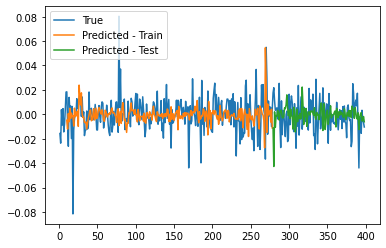

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  3010  Iterations:  9033  Loss:  0.00015377264874890292
Epochs:  3020  Iterations:  9063  Loss:  0.0001403686122406119
Epochs:  3030  Iterations:  9093  Loss:  0.0001372537450758197
Epochs:  3040  Iterations:  9123  Loss:  0.00013929643561520302
Epochs:  3050  Iterations:  9153  Loss:  0.00013765738367510494
Epochs:  3060  Iterations:  9183  Loss:  0.00013591060936353946
Epochs:  3070  Iterations:  9213  Loss:  0.00013741819141917708
Epochs:  3080  Iterations:  9243  Loss:  0.00013591106774886916
Epochs:  3090  Iterations:  9273  Loss:  0.00013724308640424473
Epochs:  3100  Iterations:  9303  Loss:  0.00013440860978638133


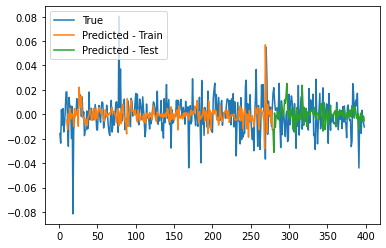

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  3110  Iterations:  9333  Loss:  0.00013594749483066457
Epochs:  3120  Iterations:  9363  Loss:  0.00015284990998528278
Epochs:  3130  Iterations:  9393  Loss:  0.00013442740176590937
Epochs:  3140  Iterations:  9423  Loss:  0.0001362669457497153
Epochs:  3150  Iterations:  9453  Loss:  0.00013228447672493834
Epochs:  3160  Iterations:  9483  Loss:  0.00017780281026110364
Epochs:  3170  Iterations:  9513  Loss:  0.00013796805615129415
Epochs:  3180  Iterations:  9543  Loss:  0.00013138870751087475
Epochs:  3190  Iterations:  9573  Loss:  0.0001333342873598061
Epochs:  3200  Iterations:  9603  Loss:  0.00013111287565455618


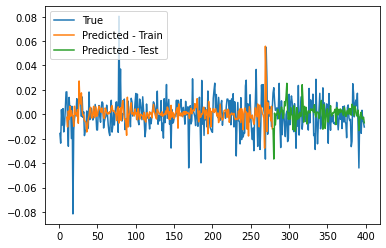

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  3210  Iterations:  9633  Loss:  0.00013623675780157404
Epochs:  3220  Iterations:  9663  Loss:  0.00013083514447013536
Epochs:  3230  Iterations:  9693  Loss:  0.00014348670932425497
Epochs:  3240  Iterations:  9723  Loss:  0.00013223267281622006
Epochs:  3250  Iterations:  9753  Loss:  0.00016445108485640958
Epochs:  3260  Iterations:  9783  Loss:  0.0001309368311315969
Epochs:  3270  Iterations:  9813  Loss:  0.00013600463656378756
Epochs:  3280  Iterations:  9843  Loss:  0.0001424377175377837
Epochs:  3290  Iterations:  9873  Loss:  0.00013566432426159736
Epochs:  3300  Iterations:  9903  Loss:  0.00013595715669604638


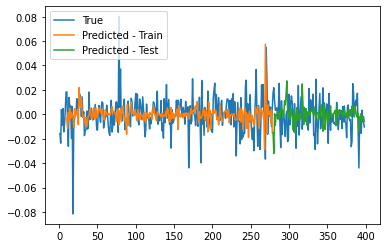

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  3310  Iterations:  9933  Loss:  0.00012986624672824595
Epochs:  3320  Iterations:  9963  Loss:  0.00017712388459282616
Epochs:  3330  Iterations:  9993  Loss:  0.00013700313320441637
Epochs:  3340  Iterations:  10023  Loss:  0.00012805412704134747
Epochs:  3350  Iterations:  10053  Loss:  0.00013173163036602395
Epochs:  3360  Iterations:  10083  Loss:  0.0001295080522443944
Epochs:  3370  Iterations:  10113  Loss:  0.0001343658107847053
Epochs:  3380  Iterations:  10143  Loss:  0.00013421115545497742
Epochs:  3390  Iterations:  10173  Loss:  0.00012709544201546427
Epochs:  3400  Iterations:  10203  Loss:  0.0001320171850238694


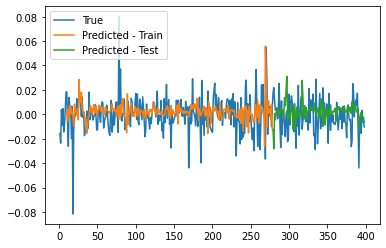

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  3410  Iterations:  10233  Loss:  0.00013784204929834232
Epochs:  3420  Iterations:  10263  Loss:  0.00012760563913616352
Epochs:  3430  Iterations:  10293  Loss:  0.00012841436394713432
Epochs:  3440  Iterations:  10323  Loss:  0.00013405487879936118
Epochs:  3450  Iterations:  10353  Loss:  0.0001258626004225031
Epochs:  3460  Iterations:  10383  Loss:  0.00015654327338173366
Epochs:  3470  Iterations:  10413  Loss:  0.00012506384549245317
Epochs:  3480  Iterations:  10443  Loss:  0.00014820779930839004
Epochs:  3490  Iterations:  10473  Loss:  0.00013418010348686948
Epochs:  3500  Iterations:  10503  Loss:  0.00013277044126880355


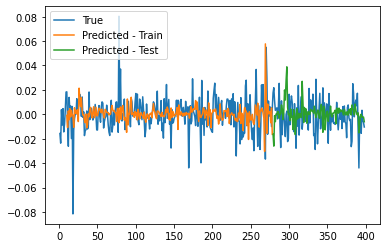

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  3510  Iterations:  10533  Loss:  0.00013212766073896395
Epochs:  3520  Iterations:  10563  Loss:  0.00013457769212739853
Epochs:  3530  Iterations:  10593  Loss:  0.0001323204742220696
Epochs:  3540  Iterations:  10623  Loss:  0.0001321341521058154
Epochs:  3550  Iterations:  10653  Loss:  0.0001332957714718456
Epochs:  3560  Iterations:  10683  Loss:  0.00013079656431121597
Epochs:  3570  Iterations:  10713  Loss:  0.00013236230491505316
Epochs:  3580  Iterations:  10743  Loss:  0.00013030323740773989
Epochs:  3590  Iterations:  10773  Loss:  0.00013090914580971003
Epochs:  3600  Iterations:  10803  Loss:  0.00012960067700381236


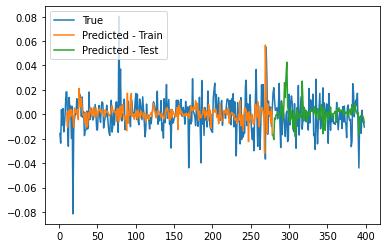

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  3610  Iterations:  10833  Loss:  0.000130244799341502
Epochs:  3620  Iterations:  10863  Loss:  0.00013003273185555977
Epochs:  3630  Iterations:  10893  Loss:  0.00013002080534837054
Epochs:  3640  Iterations:  10923  Loss:  0.00012606362179212738
Epochs:  3650  Iterations:  10953  Loss:  0.00012332153346505947
Epochs:  3660  Iterations:  10983  Loss:  0.00013092307472106768
Epochs:  3670  Iterations:  11013  Loss:  0.00013237809980637394
Epochs:  3680  Iterations:  11043  Loss:  0.00012445661620101114
Epochs:  3690  Iterations:  11073  Loss:  0.00012256593951557684
Epochs:  3700  Iterations:  11103  Loss:  0.00012209307199858208


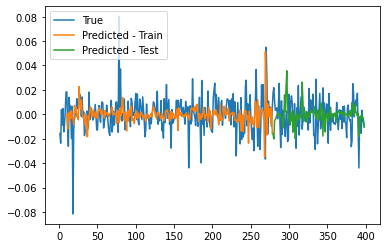

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  3710  Iterations:  11133  Loss:  0.00012164216453432648
Epochs:  3720  Iterations:  11163  Loss:  0.00013089941724805007
Epochs:  3730  Iterations:  11193  Loss:  0.000132150670348589
Epochs:  3740  Iterations:  11223  Loss:  0.00014974449732108042
Epochs:  3750  Iterations:  11253  Loss:  0.0001282177230071587
Epochs:  3760  Iterations:  11283  Loss:  0.00011700522327373619
Epochs:  3770  Iterations:  11313  Loss:  0.00011607831318845759
Epochs:  3780  Iterations:  11343  Loss:  0.00012181065812910674
Epochs:  3790  Iterations:  11373  Loss:  0.00011724186272961863
Epochs:  3800  Iterations:  11403  Loss:  0.00011541936040278718


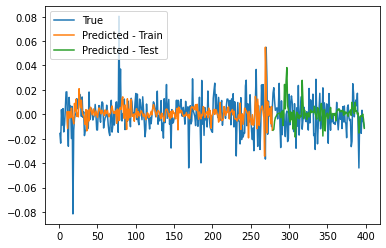

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  3810  Iterations:  11433  Loss:  0.0001156022633495013
Epochs:  3820  Iterations:  11463  Loss:  0.00012044446384607
Epochs:  3830  Iterations:  11493  Loss:  0.00011944398920604726
Epochs:  3840  Iterations:  11523  Loss:  0.00011392889481006326
Epochs:  3850  Iterations:  11553  Loss:  0.0001138004451301337
Epochs:  3860  Iterations:  11583  Loss:  0.00011946938578451712
Epochs:  3870  Iterations:  11613  Loss:  0.00012347642708239923
Epochs:  3880  Iterations:  11643  Loss:  0.00011674879381947297
Epochs:  3890  Iterations:  11673  Loss:  0.00011485172535685706
Epochs:  3900  Iterations:  11703  Loss:  0.00011704731241479749


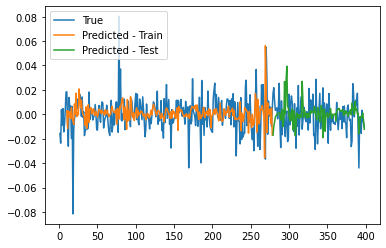

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  3910  Iterations:  11733  Loss:  0.00012286168445522586
Epochs:  3920  Iterations:  11763  Loss:  0.000124373479593487
Epochs:  3930  Iterations:  11793  Loss:  0.00012057447960008479
Epochs:  3940  Iterations:  11823  Loss:  0.00011667428225337062
Epochs:  3950  Iterations:  11853  Loss:  0.00011391155082189168
Epochs:  3960  Iterations:  11883  Loss:  0.00011500976233946858
Epochs:  3970  Iterations:  11913  Loss:  0.00012126688792098624
Epochs:  3980  Iterations:  11943  Loss:  0.00011825160315008058
Epochs:  3990  Iterations:  11973  Loss:  0.00011388770205182179
Epochs:  4000  Iterations:  12003  Loss:  0.00011516915189228409


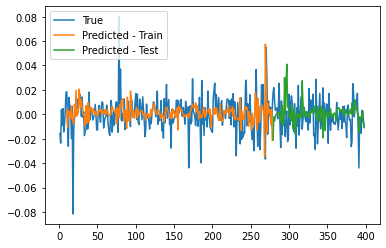

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  4010  Iterations:  12033  Loss:  0.00011693191087639813
Epochs:  4020  Iterations:  12063  Loss:  0.00011737627998324267
Epochs:  4030  Iterations:  12093  Loss:  0.00011571376641465274
Epochs:  4040  Iterations:  12123  Loss:  0.0001143180597864557
Epochs:  4050  Iterations:  12153  Loss:  0.00011563821438661155
Epochs:  4060  Iterations:  12183  Loss:  0.00011342321067786543
Epochs:  4070  Iterations:  12213  Loss:  0.00011654501698406723
Epochs:  4080  Iterations:  12243  Loss:  0.0001139237259242994
Epochs:  4090  Iterations:  12273  Loss:  0.00010926308103383538
Epochs:  4100  Iterations:  12303  Loss:  0.00010790035609412978


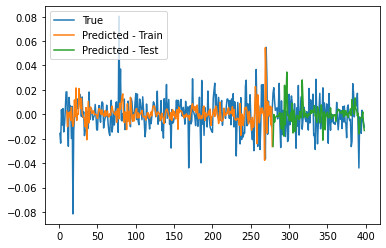

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  4110  Iterations:  12333  Loss:  0.0001072809642437278
Epochs:  4120  Iterations:  12363  Loss:  0.00010685792392450821
Epochs:  4130  Iterations:  12393  Loss:  0.00010866461987764826
Epochs:  4140  Iterations:  12423  Loss:  0.00010754218790983335
Epochs:  4150  Iterations:  12453  Loss:  0.00010668382158958896
Epochs:  4160  Iterations:  12483  Loss:  0.0001075834290986677
Epochs:  4170  Iterations:  12513  Loss:  0.00010766993417140232
Epochs:  4180  Iterations:  12543  Loss:  0.00010730590452112665
Epochs:  4190  Iterations:  12573  Loss:  0.00010516681459193933
Epochs:  4200  Iterations:  12603  Loss:  0.00011086873352420905


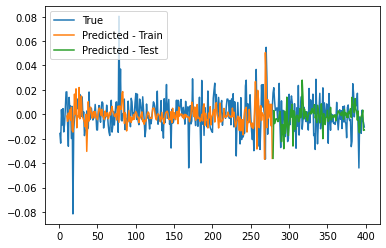

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  4210  Iterations:  12633  Loss:  0.0002253808343084529
Epochs:  4220  Iterations:  12663  Loss:  0.0002503182234552999
Epochs:  4230  Iterations:  12693  Loss:  0.00016643085837131366
Epochs:  4240  Iterations:  12723  Loss:  0.00016095733978242302
Epochs:  4250  Iterations:  12753  Loss:  0.00014601662769564427
Epochs:  4260  Iterations:  12783  Loss:  0.00015322122150488818
Epochs:  4270  Iterations:  12813  Loss:  0.00014154404683116203
Epochs:  4280  Iterations:  12843  Loss:  0.00013573527030530386
Epochs:  4290  Iterations:  12873  Loss:  0.00013747665980190504
Epochs:  4300  Iterations:  12903  Loss:  0.00013227282791679804


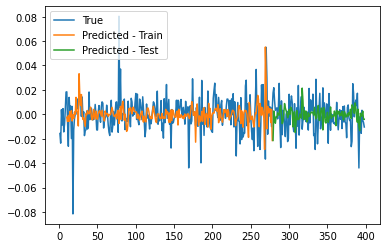

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  4310  Iterations:  12933  Loss:  0.00013874892586803375
Epochs:  4320  Iterations:  12963  Loss:  0.00013177939187395774
Epochs:  4330  Iterations:  12993  Loss:  0.000134449888112916
Epochs:  4340  Iterations:  13023  Loss:  0.00012830496628642626
Epochs:  4350  Iterations:  13053  Loss:  0.00012751968915836187
Epochs:  4360  Iterations:  13083  Loss:  0.0001380202544775481
Epochs:  4370  Iterations:  13113  Loss:  0.00012513990471537303
Epochs:  4380  Iterations:  13143  Loss:  0.00012335527723431974
Epochs:  4390  Iterations:  13173  Loss:  0.0001257971307495609
Epochs:  4400  Iterations:  13203  Loss:  0.00011975620418525068


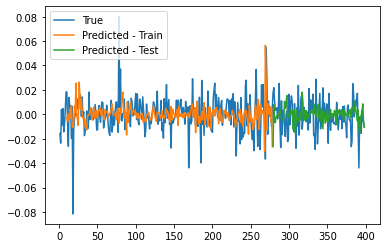

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  4410  Iterations:  13233  Loss:  0.00011996088505838998
Epochs:  4420  Iterations:  13263  Loss:  0.00011794434218851772
Epochs:  4430  Iterations:  13293  Loss:  0.00011659995501152783
Epochs:  4440  Iterations:  13323  Loss:  0.00011507982677964416
Epochs:  4450  Iterations:  13353  Loss:  0.00011316614836687222
Epochs:  4460  Iterations:  13383  Loss:  0.00011174993642271147
Epochs:  4470  Iterations:  13413  Loss:  0.00011024595975565414
Epochs:  4480  Iterations:  13443  Loss:  0.00010878453258555965
Epochs:  4490  Iterations:  13473  Loss:  0.00010764053998476204
Epochs:  4500  Iterations:  13503  Loss:  0.00010675385389428509


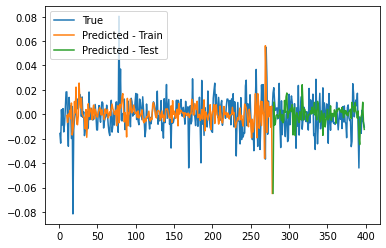

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  4510  Iterations:  13533  Loss:  0.00010620806619954237
Epochs:  4520  Iterations:  13563  Loss:  0.00010588087964909694
Epochs:  4530  Iterations:  13593  Loss:  0.00010529606712831689
Epochs:  4540  Iterations:  13623  Loss:  0.0001048478220582183
Epochs:  4550  Iterations:  13653  Loss:  0.00010445365084403117
Epochs:  4560  Iterations:  13683  Loss:  0.00010384698756145856
Epochs:  4570  Iterations:  13713  Loss:  0.00010348990887602365
Epochs:  4580  Iterations:  13743  Loss:  0.00010275158077395948
Epochs:  4590  Iterations:  13773  Loss:  0.0001018605754931438
Epochs:  4600  Iterations:  13803  Loss:  0.00010011438568350665


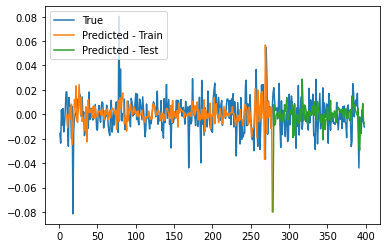

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  4610  Iterations:  13833  Loss:  9.564747820907844e-05
Epochs:  4620  Iterations:  13863  Loss:  9.461768987269654e-05
Epochs:  4630  Iterations:  13893  Loss:  9.451946997766451e-05
Epochs:  4640  Iterations:  13923  Loss:  9.530060075727913e-05
Epochs:  4650  Iterations:  13953  Loss:  9.198081564439538e-05
Epochs:  4660  Iterations:  13983  Loss:  9.470496157367354e-05
Epochs:  4670  Iterations:  14013  Loss:  9.001281190042694e-05
Epochs:  4680  Iterations:  14043  Loss:  9.388138050780981e-05
Epochs:  4690  Iterations:  14073  Loss:  8.797216491984727e-05
Epochs:  4700  Iterations:  14103  Loss:  9.461404037362324e-05


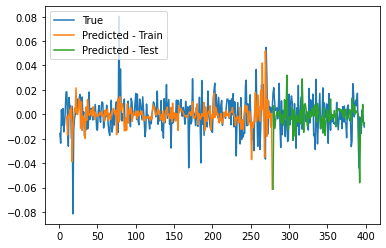

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  4710  Iterations:  14133  Loss:  8.672069786067975e-05
Epochs:  4720  Iterations:  14163  Loss:  9.090102313772756e-05
Epochs:  4730  Iterations:  14193  Loss:  8.677823204076655e-05
Epochs:  4740  Iterations:  14223  Loss:  8.542538974628162e-05
Epochs:  4750  Iterations:  14253  Loss:  8.933436568743976e-05
Epochs:  4760  Iterations:  14283  Loss:  8.798033786661108e-05
Epochs:  4770  Iterations:  14313  Loss:  8.93985843504197e-05
Epochs:  4780  Iterations:  14343  Loss:  9.864862689331251e-05
Epochs:  4790  Iterations:  14373  Loss:  0.0003455696132732555
Epochs:  4800  Iterations:  14403  Loss:  0.0002251128365363305


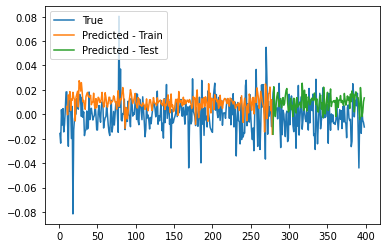

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  4810  Iterations:  14433  Loss:  0.00019317817350383848
Epochs:  4820  Iterations:  14463  Loss:  0.0001711225268081762
Epochs:  4830  Iterations:  14493  Loss:  0.00016200414150565243
Epochs:  4840  Iterations:  14523  Loss:  0.00014704567365697585
Epochs:  4850  Iterations:  14553  Loss:  0.0001405836143627918
Epochs:  4860  Iterations:  14583  Loss:  0.0001361593270606439
Epochs:  4870  Iterations:  14613  Loss:  0.0001430353950127028
Epochs:  4880  Iterations:  14643  Loss:  0.0001296008619344017
Epochs:  4890  Iterations:  14673  Loss:  0.00012603892173501663
Epochs:  4900  Iterations:  14703  Loss:  0.00012515175815982124


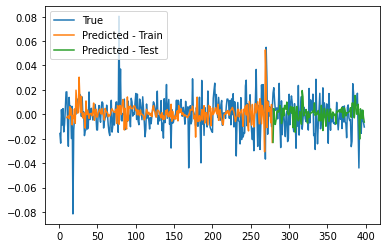

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  4910  Iterations:  14733  Loss:  0.00013238881122864163
Epochs:  4920  Iterations:  14763  Loss:  0.00012263785811228445
Epochs:  4930  Iterations:  14793  Loss:  0.00012317997455587223
Epochs:  4940  Iterations:  14823  Loss:  0.00012886062601561812
Epochs:  4950  Iterations:  14853  Loss:  0.00011814456214172726
Epochs:  4960  Iterations:  14883  Loss:  0.00011625784615413674
Epochs:  4970  Iterations:  14913  Loss:  0.00011539002025529044
Epochs:  4980  Iterations:  14943  Loss:  0.0001158366374814553
Epochs:  4990  Iterations:  14973  Loss:  0.00012602055479267923
Epochs:  5000  Iterations:  15003  Loss:  0.00011638920720239791


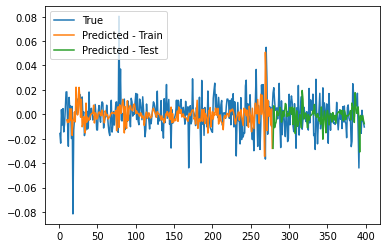

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  5010  Iterations:  15033  Loss:  0.00011073100320876013
Epochs:  5020  Iterations:  15063  Loss:  0.00011022425860574003
Epochs:  5030  Iterations:  15093  Loss:  0.00012029169738525525
Epochs:  5040  Iterations:  15123  Loss:  0.0001228664708226764
Epochs:  5050  Iterations:  15153  Loss:  0.00010720774002948019
Epochs:  5060  Iterations:  15183  Loss:  0.00010737878255895339
Epochs:  5070  Iterations:  15213  Loss:  0.00011661418405613706
Epochs:  5080  Iterations:  15243  Loss:  0.0001160166696839345
Epochs:  5090  Iterations:  15273  Loss:  0.00010491273496882059
Epochs:  5100  Iterations:  15303  Loss:  0.00010358844785211356


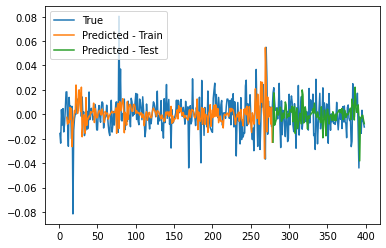

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  5110  Iterations:  15333  Loss:  0.00011066815720065885
Epochs:  5120  Iterations:  15363  Loss:  0.00011082299564198668
Epochs:  5130  Iterations:  15393  Loss:  0.00010250761662670509
Epochs:  5140  Iterations:  15423  Loss:  0.00010779658229391013
Epochs:  5150  Iterations:  15453  Loss:  0.00010498961394963165
Epochs:  5160  Iterations:  15483  Loss:  0.0001003948086690798
Epochs:  5170  Iterations:  15513  Loss:  9.627621250274387e-05
Epochs:  5180  Iterations:  15543  Loss:  9.56307503656717e-05
Epochs:  5190  Iterations:  15573  Loss:  0.00010161422324017622
Epochs:  5200  Iterations:  15603  Loss:  0.00010180026341307287


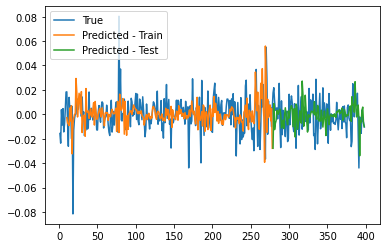

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  5210  Iterations:  15633  Loss:  9.372840592429081e-05
Epochs:  5220  Iterations:  15663  Loss:  9.581318211833907e-05
Epochs:  5230  Iterations:  15693  Loss:  0.00010078426809438194
Epochs:  5240  Iterations:  15723  Loss:  9.341390007951607e-05
Epochs:  5250  Iterations:  15753  Loss:  8.708879105749172e-05
Epochs:  5260  Iterations:  15783  Loss:  9.063674830637562e-05
Epochs:  5270  Iterations:  15813  Loss:  0.00012298048507849066
Epochs:  5280  Iterations:  15843  Loss:  9.868989885338426e-05
Epochs:  5290  Iterations:  15873  Loss:  8.21084419158069e-05
Epochs:  5300  Iterations:  15903  Loss:  7.856797455474407e-05


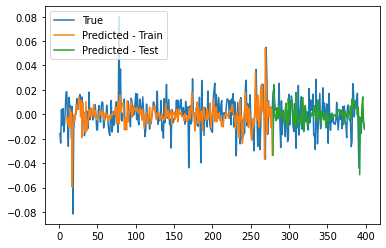

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  5310  Iterations:  15933  Loss:  7.666395549676963e-05
Epochs:  5320  Iterations:  15963  Loss:  7.778376069230337e-05
Epochs:  5330  Iterations:  15993  Loss:  8.529057989411133e-05
Epochs:  5340  Iterations:  16023  Loss:  8.491933961825755e-05
Epochs:  5350  Iterations:  16053  Loss:  0.00010963833483401686
Epochs:  5360  Iterations:  16083  Loss:  7.796892365756018e-05
Epochs:  5370  Iterations:  16113  Loss:  7.342405719631036e-05
Epochs:  5380  Iterations:  16143  Loss:  7.355222434550039e-05
Epochs:  5390  Iterations:  16173  Loss:  7.651328132851631e-05
Epochs:  5400  Iterations:  16203  Loss:  8.477964972068246e-05


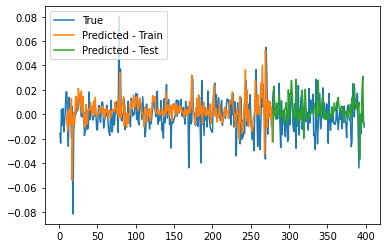

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  5410  Iterations:  16233  Loss:  7.530245026525033e-05
Epochs:  5420  Iterations:  16263  Loss:  6.820109263117047e-05
Epochs:  5430  Iterations:  16293  Loss:  6.725823383627964e-05
Epochs:  5440  Iterations:  16323  Loss:  6.801870267736376e-05
Epochs:  5450  Iterations:  16353  Loss:  7.516728040476058e-05
Epochs:  5460  Iterations:  16383  Loss:  7.10982894058058e-05
Epochs:  5470  Iterations:  16413  Loss:  6.45272209756816e-05
Epochs:  5480  Iterations:  16443  Loss:  6.67392258340745e-05
Epochs:  5490  Iterations:  16473  Loss:  6.560146236248936e-05
Epochs:  5500  Iterations:  16503  Loss:  6.966729097257485e-05


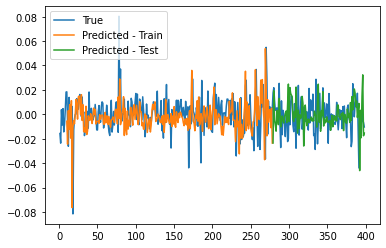

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  5510  Iterations:  16533  Loss:  7.16771361718808e-05
Epochs:  5520  Iterations:  16563  Loss:  0.00010980684783135075
Epochs:  5530  Iterations:  16593  Loss:  6.63747159705963e-05
Epochs:  5540  Iterations:  16623  Loss:  6.544790941613125e-05
Epochs:  5550  Iterations:  16653  Loss:  7.182885792644811e-05
Epochs:  5560  Iterations:  16683  Loss:  8.007238193386002e-05
Epochs:  5570  Iterations:  16713  Loss:  6.519864139894101e-05
Epochs:  5580  Iterations:  16743  Loss:  7.063282191666076e-05
Epochs:  5590  Iterations:  16773  Loss:  6.174363109797316e-05
Epochs:  5600  Iterations:  16803  Loss:  7.166618100503304e-05


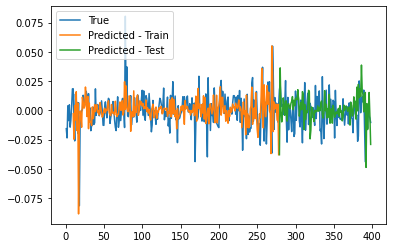

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  5610  Iterations:  16833  Loss:  6.03655474454475e-05
Epochs:  5620  Iterations:  16863  Loss:  7.196946118407747e-05
Epochs:  5630  Iterations:  16893  Loss:  5.914435898072649e-05
Epochs:  5640  Iterations:  16923  Loss:  5.5268830607246855e-05
Epochs:  5650  Iterations:  16953  Loss:  5.4774632644694066e-05
Epochs:  5660  Iterations:  16983  Loss:  5.8498801384606246e-05
Epochs:  5670  Iterations:  17013  Loss:  5.815511527392422e-05
Epochs:  5680  Iterations:  17043  Loss:  6.30851902011879e-05
Epochs:  5690  Iterations:  17073  Loss:  5.375881346481037e-05
Epochs:  5700  Iterations:  17103  Loss:  7.527491319099984e-05


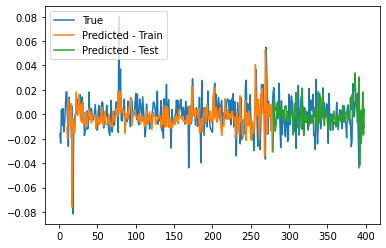

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  5710  Iterations:  17133  Loss:  5.2234970856564665e-05
Epochs:  5720  Iterations:  17163  Loss:  5.3065719991233586e-05
Epochs:  5730  Iterations:  17193  Loss:  5.6058431861553494e-05
Epochs:  5740  Iterations:  17223  Loss:  0.00010988380199705716
Epochs:  5750  Iterations:  17253  Loss:  5.5254112718709315e-05
Epochs:  5760  Iterations:  17283  Loss:  4.974047055839037e-05
Epochs:  5770  Iterations:  17313  Loss:  4.557201233031568e-05
Epochs:  5780  Iterations:  17343  Loss:  4.743109760359706e-05
Epochs:  5790  Iterations:  17373  Loss:  5.9619069209778296e-05
Epochs:  5800  Iterations:  17403  Loss:  4.606146649166476e-05


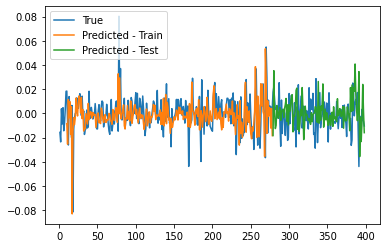

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  5810  Iterations:  17433  Loss:  4.580912142652475e-05
Epochs:  5820  Iterations:  17463  Loss:  4.890674908134921e-05
Epochs:  5830  Iterations:  17493  Loss:  3.9375896524992036e-05
Epochs:  5840  Iterations:  17523  Loss:  5.6974612258879155e-05
Epochs:  5850  Iterations:  17553  Loss:  4.4002475533488905e-05
Epochs:  5860  Iterations:  17583  Loss:  6.430954636016395e-05
Epochs:  5870  Iterations:  17613  Loss:  5.1888277994294185e-05
Epochs:  5880  Iterations:  17643  Loss:  4.0676026439238434e-05
Epochs:  5890  Iterations:  17673  Loss:  5.528996515143566e-05
Epochs:  5900  Iterations:  17703  Loss:  4.173538187994078e-05


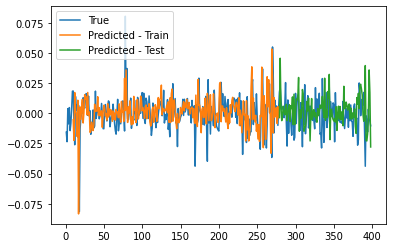

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  5910  Iterations:  17733  Loss:  5.0720045692287385e-05
Epochs:  5920  Iterations:  17763  Loss:  2.9401664808877587e-05
Epochs:  5930  Iterations:  17793  Loss:  3.824883166695751e-05
Epochs:  5940  Iterations:  17823  Loss:  4.713634037519417e-05
Epochs:  5950  Iterations:  17853  Loss:  4.235087529499045e-05
Epochs:  5960  Iterations:  17883  Loss:  3.599721154993555e-05
Epochs:  5970  Iterations:  17913  Loss:  3.6560753869707696e-05
Epochs:  5980  Iterations:  17943  Loss:  4.457839137709622e-05
Epochs:  5990  Iterations:  17973  Loss:  3.4973468549045115e-05
Epochs:  6000  Iterations:  18003  Loss:  3.884974527560795e-05


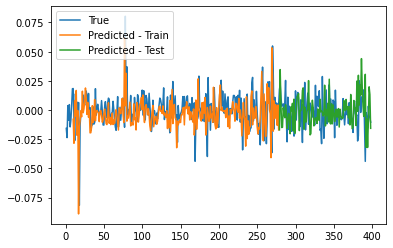

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  6010  Iterations:  18033  Loss:  4.684747530821672e-05
Epochs:  6020  Iterations:  18063  Loss:  2.6835858686051022e-05
Epochs:  6030  Iterations:  18093  Loss:  4.760632252024758e-05
Epochs:  6040  Iterations:  18123  Loss:  2.848796960582452e-05
Epochs:  6050  Iterations:  18153  Loss:  2.8217319140821928e-05
Epochs:  6060  Iterations:  18183  Loss:  3.251327476997782e-05
Epochs:  6070  Iterations:  18213  Loss:  2.8488475436461158e-05
Epochs:  6080  Iterations:  18243  Loss:  4.332034435113504e-05
Epochs:  6090  Iterations:  18273  Loss:  3.183967449634414e-05
Epochs:  6100  Iterations:  18303  Loss:  2.7320314378205996e-05


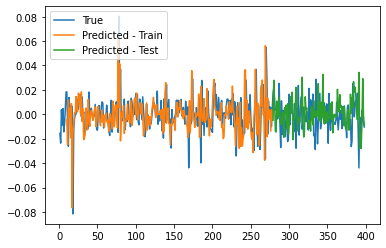

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  6110  Iterations:  18333  Loss:  2.490403687716025e-05
Epochs:  6120  Iterations:  18363  Loss:  6.025063460886789e-05
Epochs:  6130  Iterations:  18393  Loss:  2.3694735697669483e-05
Epochs:  6140  Iterations:  18423  Loss:  2.1017544365046586e-05
Epochs:  6150  Iterations:  18453  Loss:  4.098102908756118e-05
Epochs:  6160  Iterations:  18483  Loss:  1.8768169184113503e-05
Epochs:  6170  Iterations:  18513  Loss:  2.0811174332872422e-05
Epochs:  6180  Iterations:  18543  Loss:  1.244281776043484e-05
Epochs:  6190  Iterations:  18573  Loss:  4.9607499628715836e-05
Epochs:  6200  Iterations:  18603  Loss:  3.521047695661158e-05


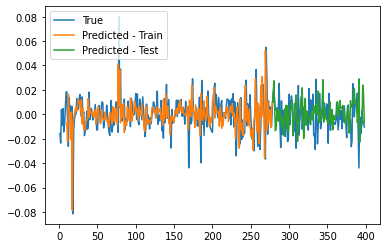

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  6210  Iterations:  18633  Loss:  1.8514433387887646e-05
Epochs:  6220  Iterations:  18663  Loss:  1.797211424066821e-05
Epochs:  6230  Iterations:  18693  Loss:  1.128355082376705e-05
Epochs:  6240  Iterations:  18723  Loss:  3.165266177044638e-05
Epochs:  6250  Iterations:  18753  Loss:  1.4050490941978447e-05
Epochs:  6260  Iterations:  18783  Loss:  4.439360782271251e-05
Epochs:  6270  Iterations:  18813  Loss:  1.1408472081105478e-05
Epochs:  6280  Iterations:  18843  Loss:  3.541320954051722e-05
Epochs:  6290  Iterations:  18873  Loss:  2.3623823532640625e-05
Epochs:  6300  Iterations:  18903  Loss:  1.1479827511114612e-05


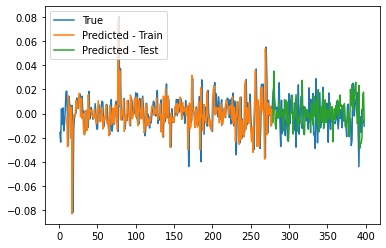

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  6310  Iterations:  18933  Loss:  7.819070958703378e-06
Epochs:  6320  Iterations:  18963  Loss:  5.861654972250108e-05
Epochs:  6330  Iterations:  18993  Loss:  1.3365743219158807e-05
Epochs:  6340  Iterations:  19023  Loss:  8.692295750734047e-06
Epochs:  6350  Iterations:  19053  Loss:  2.3872820141453605e-05
Epochs:  6360  Iterations:  19083  Loss:  2.771657576280025e-05
Epochs:  6370  Iterations:  19113  Loss:  8.288499259379023e-06
Epochs:  6380  Iterations:  19143  Loss:  1.5144179087656084e-05
Epochs:  6390  Iterations:  19173  Loss:  2.0473749979525262e-05
Epochs:  6400  Iterations:  19203  Loss:  8.77513775776606e-06


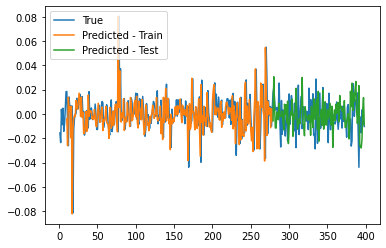

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  6410  Iterations:  19233  Loss:  1.1871480334472532e-05
Epochs:  6420  Iterations:  19263  Loss:  8.543429809530304e-06
Epochs:  6430  Iterations:  19293  Loss:  1.1208469004486687e-05
Epochs:  6440  Iterations:  19323  Loss:  3.478095216754203e-05
Epochs:  6450  Iterations:  19353  Loss:  1.3614822516198425e-05
Epochs:  6460  Iterations:  19383  Loss:  5.021790305666703e-06
Epochs:  6470  Iterations:  19413  Loss:  4.184801355222589e-06
Epochs:  6480  Iterations:  19443  Loss:  1.7843636366402887e-05
Epochs:  6490  Iterations:  19473  Loss:  2.8670481697190553e-05
Epochs:  6500  Iterations:  19503  Loss:  1.9936522827871766e-05


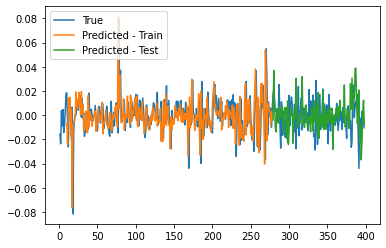

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  6510  Iterations:  19533  Loss:  5.691993843962943e-06
Epochs:  6520  Iterations:  19563  Loss:  5.123853270561085e-06
Epochs:  6530  Iterations:  19593  Loss:  5.445514261737117e-06
Epochs:  6540  Iterations:  19623  Loss:  8.069555178735754e-06
Epochs:  6550  Iterations:  19653  Loss:  6.882016217938751e-06
Epochs:  6560  Iterations:  19683  Loss:  3.3023175494880284e-06
Epochs:  6570  Iterations:  19713  Loss:  3.6491312206029156e-06
Epochs:  6580  Iterations:  19743  Loss:  8.96407224596866e-06
Epochs:  6590  Iterations:  19773  Loss:  5.401553789852187e-05
Epochs:  6600  Iterations:  19803  Loss:  1.1504639284491228e-05


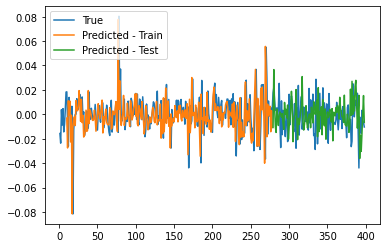

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  6610  Iterations:  19833  Loss:  5.7489188331298164e-06
Epochs:  6620  Iterations:  19863  Loss:  2.6638384345763675e-06
Epochs:  6630  Iterations:  19893  Loss:  2.2791932374014814e-06
Epochs:  6640  Iterations:  19923  Loss:  3.954021887390506e-06
Epochs:  6650  Iterations:  19953  Loss:  1.199300125639032e-05
Epochs:  6660  Iterations:  19983  Loss:  1.1937880344703444e-05
Epochs:  6670  Iterations:  20013  Loss:  3.6861121846717046e-06
Epochs:  6680  Iterations:  20043  Loss:  2.4457356270583355e-06
Epochs:  6690  Iterations:  20073  Loss:  3.7354402593337e-06
Epochs:  6700  Iterations:  20103  Loss:  8.795036895511052e-06


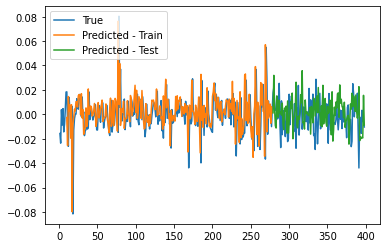

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  6710  Iterations:  20133  Loss:  6.55802227811364e-06
Epochs:  6720  Iterations:  20163  Loss:  7.981762792041991e-06
Epochs:  6730  Iterations:  20193  Loss:  6.559598925074776e-06
Epochs:  6740  Iterations:  20223  Loss:  2.3491074614412355e-06
Epochs:  6750  Iterations:  20253  Loss:  1.5852744918258093e-06
Epochs:  6760  Iterations:  20283  Loss:  1.9050641905475156e-06
Epochs:  6770  Iterations:  20313  Loss:  1.2724875167198965e-05
Epochs:  6780  Iterations:  20343  Loss:  1.4061687276504623e-05
Epochs:  6790  Iterations:  20373  Loss:  2.5924631756879535e-06
Epochs:  6800  Iterations:  20403  Loss:  1.1722631677220836e-06


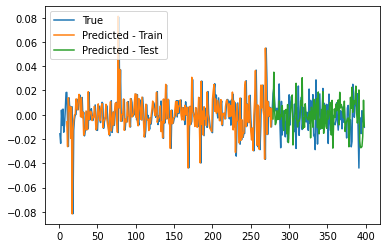

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  6810  Iterations:  20433  Loss:  9.951019777076908e-07
Epochs:  6820  Iterations:  20463  Loss:  1.0482498093248676e-06
Epochs:  6830  Iterations:  20493  Loss:  1.7611326512678716e-06
Epochs:  6840  Iterations:  20523  Loss:  2.2352008196927877e-06
Epochs:  6850  Iterations:  20553  Loss:  1.9508440421608006e-06
Epochs:  6860  Iterations:  20583  Loss:  9.700357033182172e-07
Epochs:  6870  Iterations:  20613  Loss:  6.6171999246004516e-06
Epochs:  6880  Iterations:  20643  Loss:  3.875032840975715e-05
Epochs:  6890  Iterations:  20673  Loss:  0.00012068571171160632
Epochs:  6900  Iterations:  20703  Loss:  4.063192773173796e-05


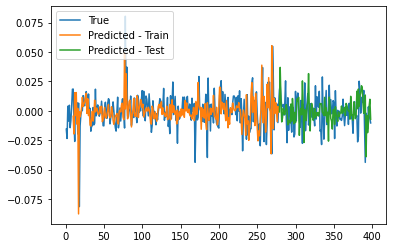

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  6910  Iterations:  20733  Loss:  1.8207988034646405e-05
Epochs:  6920  Iterations:  20763  Loss:  9.854828723139994e-06
Epochs:  6930  Iterations:  20793  Loss:  5.745586037164685e-06
Epochs:  6940  Iterations:  20823  Loss:  3.6864695687199855e-06
Epochs:  6950  Iterations:  20853  Loss:  3.2583990237829616e-06
Epochs:  6960  Iterations:  20883  Loss:  1.353814521583748e-05
Epochs:  6970  Iterations:  20913  Loss:  4.710317701513607e-06
Epochs:  6980  Iterations:  20943  Loss:  1.5079557235490408e-06
Epochs:  6990  Iterations:  20973  Loss:  1.0261822816678052e-06
Epochs:  7000  Iterations:  21003  Loss:  8.496860051110389e-07


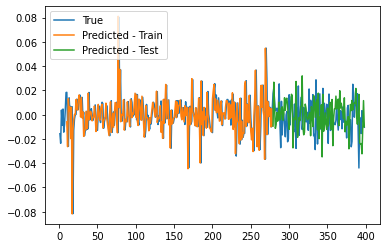

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  7010  Iterations:  21033  Loss:  1.0652010331568817e-06
Epochs:  7020  Iterations:  21063  Loss:  1.218160392113532e-06
Epochs:  7030  Iterations:  21093  Loss:  1.0143315497164924e-06
Epochs:  7040  Iterations:  21123  Loss:  6.839633594305875e-07
Epochs:  7050  Iterations:  21153  Loss:  5.337101415629301e-07
Epochs:  7060  Iterations:  21183  Loss:  6.0558897606218425e-06
Epochs:  7070  Iterations:  21213  Loss:  4.0987863030750304e-05
Epochs:  7080  Iterations:  21243  Loss:  6.639929286696618e-06
Epochs:  7090  Iterations:  21273  Loss:  3.4770710802452718e-06
Epochs:  7100  Iterations:  21303  Loss:  3.9854445882762475e-06


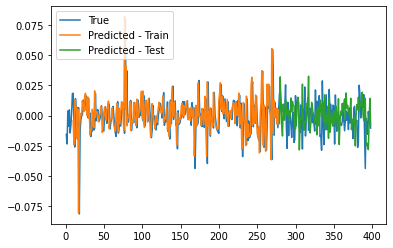

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  7110  Iterations:  21333  Loss:  1.8513378942467777e-06
Epochs:  7120  Iterations:  21363  Loss:  8.086001723010364e-07
Epochs:  7130  Iterations:  21393  Loss:  8.723927180653845e-07
Epochs:  7140  Iterations:  21423  Loss:  5.615948381887392e-07
Epochs:  7150  Iterations:  21453  Loss:  1.0891200948511444e-06
Epochs:  7160  Iterations:  21483  Loss:  7.3527419885977e-07
Epochs:  7170  Iterations:  21513  Loss:  3.0363387395482277e-06
Epochs:  7180  Iterations:  21543  Loss:  5.817808899640416e-05
Epochs:  7190  Iterations:  21573  Loss:  3.202193950831619e-05
Epochs:  7200  Iterations:  21603  Loss:  9.89381533145206e-06


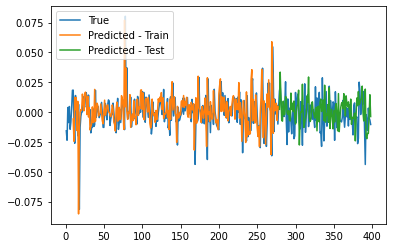

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  7210  Iterations:  21633  Loss:  2.1478856713959735e-06
Epochs:  7220  Iterations:  21663  Loss:  7.354852336050044e-07
Epochs:  7230  Iterations:  21693  Loss:  5.200403911942431e-07
Epochs:  7240  Iterations:  21723  Loss:  4.146359403970716e-07
Epochs:  7250  Iterations:  21753  Loss:  1.1500896543263177e-06
Epochs:  7260  Iterations:  21783  Loss:  3.829000500369754e-07
Epochs:  7270  Iterations:  21813  Loss:  5.314980408381113e-07
Epochs:  7280  Iterations:  21843  Loss:  5.832442108536876e-07
Epochs:  7290  Iterations:  21873  Loss:  9.540959240439406e-07
Epochs:  7300  Iterations:  21903  Loss:  8.279515573879811e-07


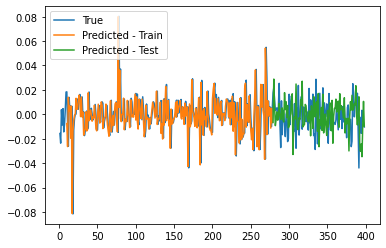

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  7310  Iterations:  21933  Loss:  2.2013613391417644e-07
Epochs:  7320  Iterations:  21963  Loss:  7.963499157881415e-07
Epochs:  7330  Iterations:  21993  Loss:  2.828683515569234e-07
Epochs:  7340  Iterations:  22023  Loss:  1.3089963128246989e-06
Epochs:  7350  Iterations:  22053  Loss:  7.790464981856834e-06
Epochs:  7360  Iterations:  22083  Loss:  4.28208744172783e-05
Epochs:  7370  Iterations:  22113  Loss:  0.00022193181697123995
Epochs:  7380  Iterations:  22143  Loss:  0.00013049979497736786
Epochs:  7390  Iterations:  22173  Loss:  0.00011514763415713485
Epochs:  7400  Iterations:  22203  Loss:  0.00010120394532956804


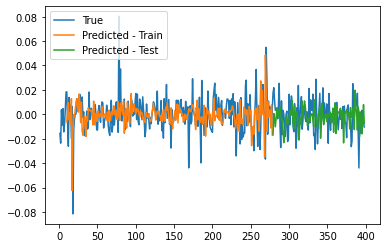

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  7410  Iterations:  22233  Loss:  7.83827589430075e-05
Epochs:  7420  Iterations:  22263  Loss:  7.345341274837362e-05
Epochs:  7430  Iterations:  22293  Loss:  0.00013130924586827555
Epochs:  7440  Iterations:  22323  Loss:  7.317917394781641e-05
Epochs:  7450  Iterations:  22353  Loss:  6.229387188720163e-05
Epochs:  7460  Iterations:  22383  Loss:  6.034239853155062e-05
Epochs:  7470  Iterations:  22413  Loss:  5.73025113226322e-05
Epochs:  7480  Iterations:  22443  Loss:  5.812506045306994e-05
Epochs:  7490  Iterations:  22473  Loss:  5.2077873893570846e-05
Epochs:  7500  Iterations:  22503  Loss:  6.494638849593078e-05


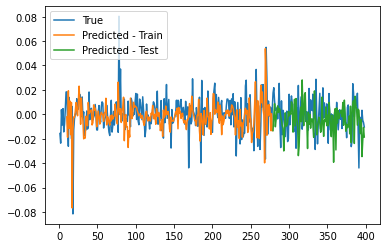

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  7510  Iterations:  22533  Loss:  5.086814780952409e-05
Epochs:  7520  Iterations:  22563  Loss:  5.0159314772220874e-05
Epochs:  7530  Iterations:  22593  Loss:  8.227485401827532e-05
Epochs:  7540  Iterations:  22623  Loss:  4.695923147816453e-05
Epochs:  7550  Iterations:  22653  Loss:  8.752073578458901e-05
Epochs:  7560  Iterations:  22683  Loss:  5.0682096646899787e-05
Epochs:  7570  Iterations:  22713  Loss:  3.327854674732104e-05
Epochs:  7580  Iterations:  22743  Loss:  8.427038483205251e-05
Epochs:  7590  Iterations:  22773  Loss:  4.6974780464855335e-05
Epochs:  7600  Iterations:  22803  Loss:  2.9837070343319283e-05


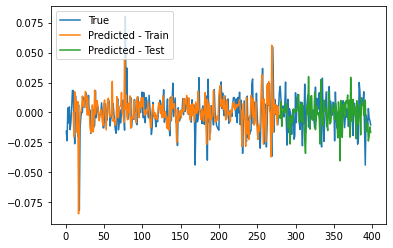

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  7610  Iterations:  22833  Loss:  4.975918636773713e-05
Epochs:  7620  Iterations:  22863  Loss:  4.899321644794933e-05
Epochs:  7630  Iterations:  22893  Loss:  2.6969527255005232e-05
Epochs:  7640  Iterations:  22923  Loss:  3.3948586406040704e-05
Epochs:  7650  Iterations:  22953  Loss:  3.317793112955769e-05
Epochs:  7660  Iterations:  22983  Loss:  2.3368637054469826e-05
Epochs:  7670  Iterations:  23013  Loss:  8.259667204886985e-05
Epochs:  7680  Iterations:  23043  Loss:  4.269773785381403e-05
Epochs:  7690  Iterations:  23073  Loss:  2.591377134801102e-05
Epochs:  7700  Iterations:  23103  Loss:  3.823768626413463e-05


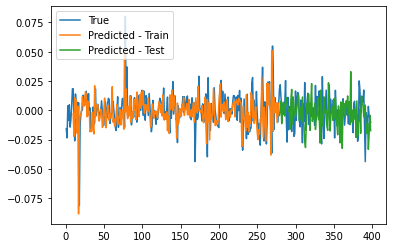

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  7710  Iterations:  23133  Loss:  2.4006784694089827e-05
Epochs:  7720  Iterations:  23163  Loss:  3.375589282465322e-05
Epochs:  7730  Iterations:  23193  Loss:  1.9014560156923228e-05
Epochs:  7740  Iterations:  23223  Loss:  2.862686036072167e-05
Epochs:  7750  Iterations:  23253  Loss:  2.057754354230686e-05
Epochs:  7760  Iterations:  23283  Loss:  2.8338551449754352e-05
Epochs:  7770  Iterations:  23313  Loss:  2.8272436490321223e-05
Epochs:  7780  Iterations:  23343  Loss:  2.5262002357825015e-05
Epochs:  7790  Iterations:  23373  Loss:  2.5939666367473062e-05
Epochs:  7800  Iterations:  23403  Loss:  1.5901124735743604e-05


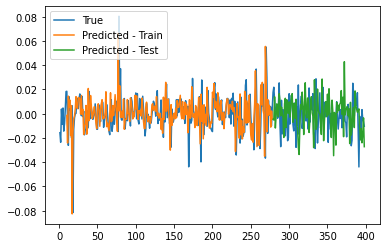

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  7810  Iterations:  23433  Loss:  2.7348482035449706e-05
Epochs:  7820  Iterations:  23463  Loss:  1.4714512190039386e-05
Epochs:  7830  Iterations:  23493  Loss:  1.9414680006472434e-05
Epochs:  7840  Iterations:  23523  Loss:  3.552171619958244e-05
Epochs:  7850  Iterations:  23553  Loss:  1.607043873264047e-05
Epochs:  7860  Iterations:  23583  Loss:  1.4026447767416054e-05
Epochs:  7870  Iterations:  23613  Loss:  1.5862858011435794e-05
Epochs:  7880  Iterations:  23643  Loss:  5.66224653084646e-05
Epochs:  7890  Iterations:  23673  Loss:  3.0044772150480032e-05
Epochs:  7900  Iterations:  23703  Loss:  1.1733184294371313e-05


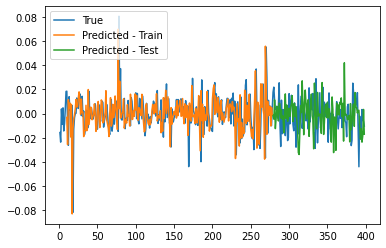

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  7910  Iterations:  23733  Loss:  8.715539668931646e-06
Epochs:  7920  Iterations:  23763  Loss:  1.4425169032013704e-05
Epochs:  7930  Iterations:  23793  Loss:  1.2069815284121432e-05
Epochs:  7940  Iterations:  23823  Loss:  2.202078849222744e-05
Epochs:  7950  Iterations:  23853  Loss:  2.1324731127000025e-05
Epochs:  7960  Iterations:  23883  Loss:  1.209523293255188e-05
Epochs:  7970  Iterations:  23913  Loss:  1.0355306358178495e-05
Epochs:  7980  Iterations:  23943  Loss:  1.0352321320776051e-05
Epochs:  7990  Iterations:  23973  Loss:  1.651370575928013e-05
Epochs:  8000  Iterations:  24003  Loss:  1.4597777161876971e-05


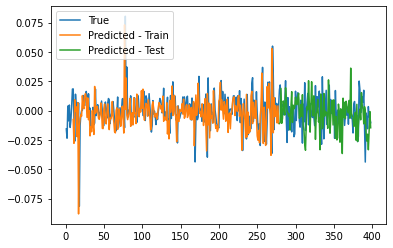

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  8010  Iterations:  24033  Loss:  9.432346056807242e-06
Epochs:  8020  Iterations:  24063  Loss:  6.247187798180676e-06
Epochs:  8030  Iterations:  24093  Loss:  1.9209231747178517e-05
Epochs:  8040  Iterations:  24123  Loss:  3.2332435997280605e-05
Epochs:  8050  Iterations:  24153  Loss:  7.985433209493445e-06
Epochs:  8060  Iterations:  24183  Loss:  5.24203446161664e-06
Epochs:  8070  Iterations:  24213  Loss:  4.159008369697403e-06
Epochs:  8080  Iterations:  24243  Loss:  1.1349526279976393e-05
Epochs:  8090  Iterations:  24273  Loss:  3.7118859230152644e-05
Epochs:  8100  Iterations:  24303  Loss:  1.3824146587163947e-05


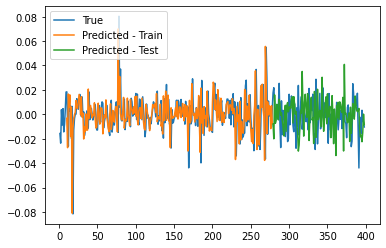

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  8110  Iterations:  24333  Loss:  4.98731458264956e-06
Epochs:  8120  Iterations:  24363  Loss:  4.416255947603531e-06
Epochs:  8130  Iterations:  24393  Loss:  5.048980786644582e-06
Epochs:  8140  Iterations:  24423  Loss:  1.0001233363254869e-05
Epochs:  8150  Iterations:  24453  Loss:  1.0640864881376425e-05
Epochs:  8160  Iterations:  24483  Loss:  3.1494475858077443e-05
Epochs:  8170  Iterations:  24513  Loss:  2.7401583186777618e-05
Epochs:  8180  Iterations:  24543  Loss:  9.066410977235742e-06
Epochs:  8190  Iterations:  24573  Loss:  3.055012361604289e-06
Epochs:  8200  Iterations:  24603  Loss:  3.193441052928847e-06


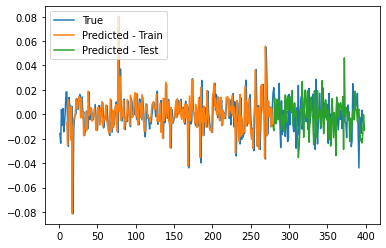

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  8210  Iterations:  24633  Loss:  1.9016864770312243e-06
Epochs:  8220  Iterations:  24663  Loss:  2.008120858931761e-06
Epochs:  8230  Iterations:  24693  Loss:  9.328170563094318e-06
Epochs:  8240  Iterations:  24723  Loss:  3.98417396354489e-05
Epochs:  8250  Iterations:  24753  Loss:  4.647724927053787e-05
Epochs:  8260  Iterations:  24783  Loss:  1.2133905329392292e-05
Epochs:  8270  Iterations:  24813  Loss:  2.909680048901464e-06
Epochs:  8280  Iterations:  24843  Loss:  2.4809788120213247e-06
Epochs:  8290  Iterations:  24873  Loss:  2.194466125852538e-06
Epochs:  8300  Iterations:  24903  Loss:  3.944301710134823e-06


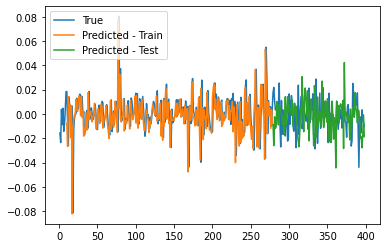

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  8310  Iterations:  24933  Loss:  2.837404016039121e-06
Epochs:  8320  Iterations:  24963  Loss:  2.6666342094472384e-06
Epochs:  8330  Iterations:  24993  Loss:  2.2556828488025835e-06
Epochs:  8340  Iterations:  25023  Loss:  1.0621887440720457e-05
Epochs:  8350  Iterations:  25053  Loss:  3.801264028879814e-06
Epochs:  8360  Iterations:  25083  Loss:  5.147287690003092e-06
Epochs:  8370  Iterations:  25113  Loss:  8.789772437012289e-06
Epochs:  8380  Iterations:  25143  Loss:  8.794555469648913e-06
Epochs:  8390  Iterations:  25173  Loss:  1.4195677067618817e-05
Epochs:  8400  Iterations:  25203  Loss:  3.4172252223167256e-05


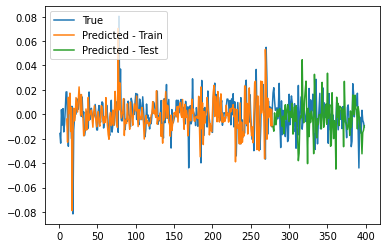

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  8410  Iterations:  25233  Loss:  7.225882897425133e-05
Epochs:  8420  Iterations:  25263  Loss:  1.2542170225060545e-05
Epochs:  8430  Iterations:  25293  Loss:  2.8594974660715402e-06
Epochs:  8440  Iterations:  25323  Loss:  1.2736310660936094e-06
Epochs:  8450  Iterations:  25353  Loss:  9.016132670088458e-07
Epochs:  8460  Iterations:  25383  Loss:  6.336757264098954e-07
Epochs:  8470  Iterations:  25413  Loss:  1.331307134459318e-06
Epochs:  8480  Iterations:  25443  Loss:  1.120766686568686e-06
Epochs:  8490  Iterations:  25473  Loss:  1.5012682107832613e-06
Epochs:  8500  Iterations:  25503  Loss:  1.178356100695055e-06


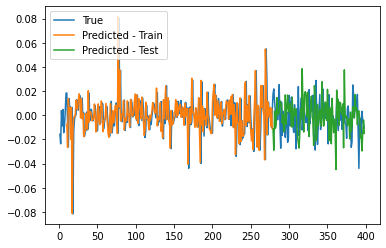

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  8510  Iterations:  25533  Loss:  5.220085828720281e-05
Epochs:  8520  Iterations:  25563  Loss:  1.417382009094581e-05
Epochs:  8530  Iterations:  25593  Loss:  3.12046768158325e-06
Epochs:  8540  Iterations:  25623  Loss:  1.4185620405745187e-06
Epochs:  8550  Iterations:  25653  Loss:  8.26159625451813e-07
Epochs:  8560  Iterations:  25683  Loss:  9.762650338511019e-07
Epochs:  8570  Iterations:  25713  Loss:  3.750302055571808e-07
Epochs:  8580  Iterations:  25743  Loss:  1.7343143904705964e-06
Epochs:  8590  Iterations:  25773  Loss:  5.450116142095377e-07
Epochs:  8600  Iterations:  25803  Loss:  1.478814886842391e-07


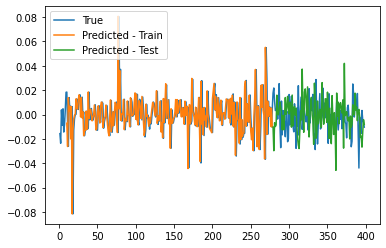

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  8610  Iterations:  25833  Loss:  2.8326607927435057e-06
Epochs:  8620  Iterations:  25863  Loss:  5.050754078676315e-07
Epochs:  8630  Iterations:  25893  Loss:  5.765647207075139e-07
Epochs:  8640  Iterations:  25923  Loss:  8.366791159157098e-07
Epochs:  8650  Iterations:  25953  Loss:  0.00018027130863629282
Epochs:  8660  Iterations:  25983  Loss:  8.454043442422214e-05
Epochs:  8670  Iterations:  26013  Loss:  4.5329890554057783e-05
Epochs:  8680  Iterations:  26043  Loss:  4.0138463039814574e-05
Epochs:  8690  Iterations:  26073  Loss:  3.450190016944058e-05
Epochs:  8700  Iterations:  26103  Loss:  2.6752342857131833e-05


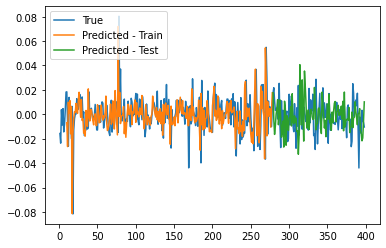

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  8710  Iterations:  26133  Loss:  2.4369976093415364e-05
Epochs:  8720  Iterations:  26163  Loss:  3.833008486253675e-05
Epochs:  8730  Iterations:  26193  Loss:  2.2703233147088515e-05
Epochs:  8740  Iterations:  26223  Loss:  2.949949324223174e-05
Epochs:  8750  Iterations:  26253  Loss:  6.52616308798315e-05
Epochs:  8760  Iterations:  26283  Loss:  1.5071818476523427e-05
Epochs:  8770  Iterations:  26313  Loss:  9.330078171387868e-06
Epochs:  8780  Iterations:  26343  Loss:  6.310925073194085e-06
Epochs:  8790  Iterations:  26373  Loss:  6.276006509627526e-05
Epochs:  8800  Iterations:  26403  Loss:  2.283910968496154e-05


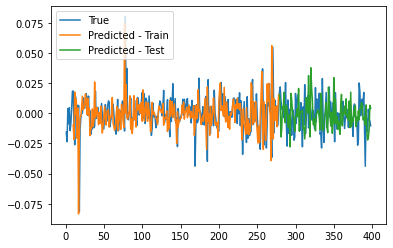

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  8810  Iterations:  26433  Loss:  8.275368514887305e-06
Epochs:  8820  Iterations:  26463  Loss:  3.258128003835736e-05
Epochs:  8830  Iterations:  26493  Loss:  1.905296100327784e-05
Epochs:  8840  Iterations:  26523  Loss:  2.0646321142218465e-05
Epochs:  8850  Iterations:  26553  Loss:  2.2612173855425983e-05
Epochs:  8860  Iterations:  26583  Loss:  6.394589168697469e-06
Epochs:  8870  Iterations:  26613  Loss:  3.6447095747386507e-06
Epochs:  8880  Iterations:  26643  Loss:  2.56789459148384e-06
Epochs:  8890  Iterations:  26673  Loss:  2.0635524548377284e-06
Epochs:  8900  Iterations:  26703  Loss:  1.585874148683312e-05


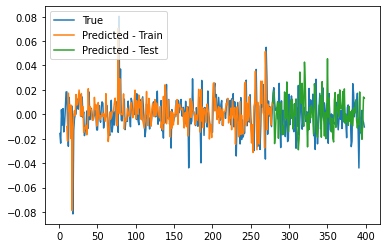

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  8910  Iterations:  26733  Loss:  3.754772054283725e-05
Epochs:  8920  Iterations:  26763  Loss:  0.00018694887694437057
Epochs:  8930  Iterations:  26793  Loss:  4.510902863330557e-05
Epochs:  8940  Iterations:  26823  Loss:  1.904702474083327e-05
Epochs:  8950  Iterations:  26853  Loss:  1.8044334865408018e-05
Epochs:  8960  Iterations:  26883  Loss:  2.0384942520953093e-05
Epochs:  8970  Iterations:  26913  Loss:  1.3673084595211549e-05
Epochs:  8980  Iterations:  26943  Loss:  7.72220401283145e-06
Epochs:  8990  Iterations:  26973  Loss:  6.306367446029526e-06
Epochs:  9000  Iterations:  27003  Loss:  4.2068299960599615e-06


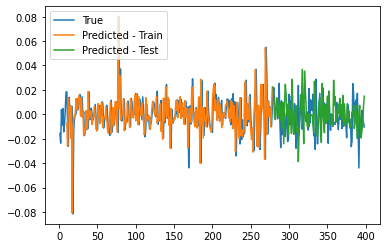

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  9010  Iterations:  27033  Loss:  1.6120658907918067e-05
Epochs:  9020  Iterations:  27063  Loss:  7.152153163284918e-05
Epochs:  9030  Iterations:  27093  Loss:  1.5872125383490736e-05
Epochs:  9040  Iterations:  27123  Loss:  5.7773680831966585e-06
Epochs:  9050  Iterations:  27153  Loss:  3.5375004028281865e-06
Epochs:  9060  Iterations:  27183  Loss:  4.477998383360197e-06
Epochs:  9070  Iterations:  27213  Loss:  2.373128836552496e-06
Epochs:  9080  Iterations:  27243  Loss:  1.7816071770463775e-06
Epochs:  9090  Iterations:  27273  Loss:  1.8019408353590431e-06
Epochs:  9100  Iterations:  27303  Loss:  1.309452766662389e-06


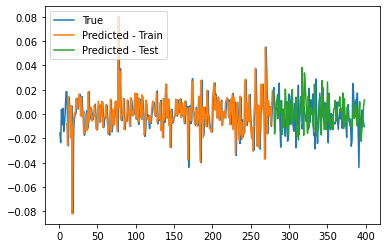

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  9110  Iterations:  27333  Loss:  5.444711083176419e-06
Epochs:  9120  Iterations:  27363  Loss:  1.951315941065938e-05
Epochs:  9130  Iterations:  27393  Loss:  3.323737814753258e-06
Epochs:  9140  Iterations:  27423  Loss:  1.5592858820430895e-06
Epochs:  9150  Iterations:  27453  Loss:  7.878175599292566e-07
Epochs:  9160  Iterations:  27483  Loss:  5.360674630120835e-07
Epochs:  9170  Iterations:  27513  Loss:  9.118186217923115e-07
Epochs:  9180  Iterations:  27543  Loss:  4.433959264934136e-07
Epochs:  9190  Iterations:  27573  Loss:  2.9814686541840274e-07
Epochs:  9200  Iterations:  27603  Loss:  4.908064880441524e-07


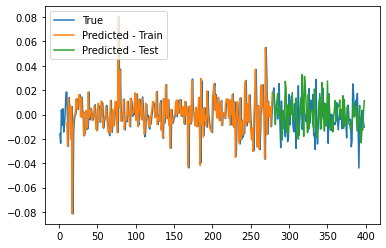

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  9210  Iterations:  27633  Loss:  5.579796470793023e-07
Epochs:  9220  Iterations:  27663  Loss:  2.654673293041772e-07
Epochs:  9230  Iterations:  27693  Loss:  2.434921218726534e-07
Epochs:  9240  Iterations:  27723  Loss:  1.2984803371788682e-06
Epochs:  9250  Iterations:  27753  Loss:  1.1057469843459936e-05
Epochs:  9260  Iterations:  27783  Loss:  4.7698749767732807e-05
Epochs:  9270  Iterations:  27813  Loss:  3.307008713212175e-05
Epochs:  9280  Iterations:  27843  Loss:  1.0989586295787982e-05
Epochs:  9290  Iterations:  27873  Loss:  2.1815370852588483e-05
Epochs:  9300  Iterations:  27903  Loss:  2.0321826317134157e-05


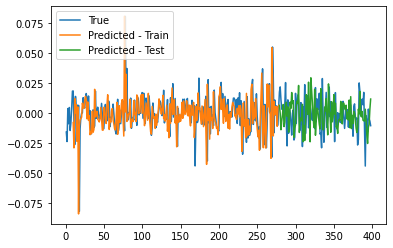

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  9310  Iterations:  27933  Loss:  8.661911465424055e-06
Epochs:  9320  Iterations:  27963  Loss:  6.378039908364978e-06
Epochs:  9330  Iterations:  27993  Loss:  5.0654973165364936e-05
Epochs:  9340  Iterations:  28023  Loss:  8.668493668058849e-06
Epochs:  9350  Iterations:  28053  Loss:  2.1217099553420365e-05
Epochs:  9360  Iterations:  28083  Loss:  3.586152331536141e-06
Epochs:  9370  Iterations:  28113  Loss:  7.220711665922863e-06
Epochs:  9380  Iterations:  28143  Loss:  1.2406156145061686e-05
Epochs:  9390  Iterations:  28173  Loss:  3.11094030773044e-06
Epochs:  9400  Iterations:  28203  Loss:  1.04115593539215e-06


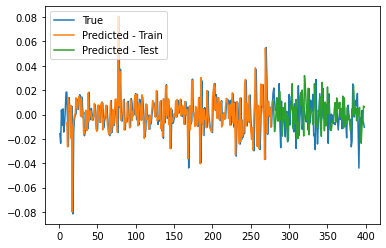

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  9410  Iterations:  28233  Loss:  9.444599887350099e-07
Epochs:  9420  Iterations:  28263  Loss:  2.6798976193731505e-06
Epochs:  9430  Iterations:  28293  Loss:  9.65577385159122e-07
Epochs:  9440  Iterations:  28323  Loss:  9.186294012882475e-07
Epochs:  9450  Iterations:  28353  Loss:  8.633177515093848e-07
Epochs:  9460  Iterations:  28383  Loss:  8.762325668006573e-07
Epochs:  9470  Iterations:  28413  Loss:  1.4510664717211814e-06
Epochs:  9480  Iterations:  28443  Loss:  1.511529556334305e-06
Epochs:  9490  Iterations:  28473  Loss:  2.473448944328993e-06
Epochs:  9500  Iterations:  28503  Loss:  2.451986015709432e-06


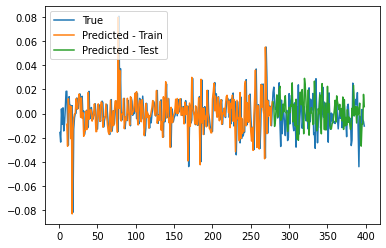

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  9510  Iterations:  28533  Loss:  1.0736401918620686e-06
Epochs:  9520  Iterations:  28563  Loss:  1.1168963737873128e-05
Epochs:  9530  Iterations:  28593  Loss:  0.00010727379655387874
Epochs:  9540  Iterations:  28623  Loss:  2.8986816611601778e-05
Epochs:  9550  Iterations:  28653  Loss:  8.062459812663292e-06
Epochs:  9560  Iterations:  28683  Loss:  1.922573180005808e-05
Epochs:  9570  Iterations:  28713  Loss:  4.136534509295113e-06
Epochs:  9580  Iterations:  28743  Loss:  2.7742002165117205e-06
Epochs:  9590  Iterations:  28773  Loss:  1.0067442843819663e-06
Epochs:  9600  Iterations:  28803  Loss:  8.091087432641567e-07


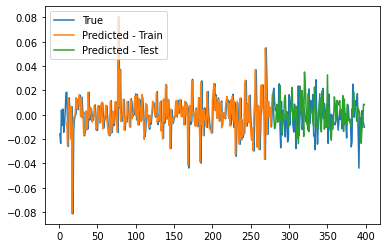

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  9610  Iterations:  28833  Loss:  5.000637960013895e-07
Epochs:  9620  Iterations:  28863  Loss:  1.243938312948482e-06
Epochs:  9630  Iterations:  28893  Loss:  2.052229509293587e-06
Epochs:  9640  Iterations:  28923  Loss:  9.809389401501296e-07
Epochs:  9650  Iterations:  28953  Loss:  5.808906754130779e-07
Epochs:  9660  Iterations:  28983  Loss:  4.714557159483472e-07
Epochs:  9670  Iterations:  29013  Loss:  2.130953925908822e-07
Epochs:  9680  Iterations:  29043  Loss:  2.096361371902352e-07
Epochs:  9690  Iterations:  29073  Loss:  4.492233453371834e-07
Epochs:  9700  Iterations:  29103  Loss:  1.0824085923862488e-06


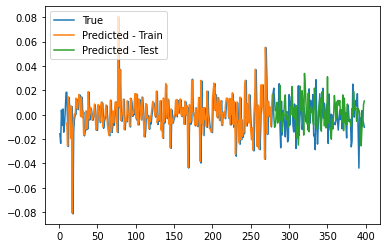

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  9710  Iterations:  29133  Loss:  1.7366239338419593e-06
Epochs:  9720  Iterations:  29163  Loss:  1.3003376958901451e-06
Epochs:  9730  Iterations:  29193  Loss:  3.7149835918626195e-07
Epochs:  9740  Iterations:  29223  Loss:  2.036683651359302e-07
Epochs:  9750  Iterations:  29253  Loss:  3.5291623608676065e-07
Epochs:  9760  Iterations:  29283  Loss:  9.27028414328864e-07
Epochs:  9770  Iterations:  29313  Loss:  2.595304901357546e-06
Epochs:  9780  Iterations:  29343  Loss:  7.653452257727622e-06
Epochs:  9790  Iterations:  29373  Loss:  9.403723864428078e-05
Epochs:  9800  Iterations:  29403  Loss:  7.327121268948152e-05


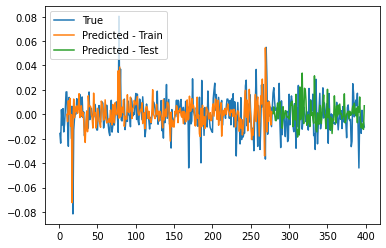

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  9810  Iterations:  29433  Loss:  1.8346096605152223e-05
Epochs:  9820  Iterations:  29463  Loss:  1.0144850269474167e-05
Epochs:  9830  Iterations:  29493  Loss:  3.2078511443008516e-05
Epochs:  9840  Iterations:  29523  Loss:  4.68180869953964e-06
Epochs:  9850  Iterations:  29553  Loss:  2.1537968658928244e-06
Epochs:  9860  Iterations:  29583  Loss:  9.687898909760406e-06
Epochs:  9870  Iterations:  29613  Loss:  1.5133989279547677e-06
Epochs:  9880  Iterations:  29643  Loss:  6.952765335318153e-07
Epochs:  9890  Iterations:  29673  Loss:  6.556482219366444e-07
Epochs:  9900  Iterations:  29703  Loss:  8.436537891990762e-07


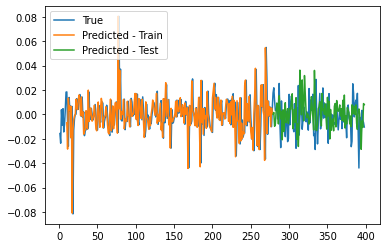

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  9910  Iterations:  29733  Loss:  6.679579761896074e-07
Epochs:  9920  Iterations:  29763  Loss:  2.9398248457823684e-07
Epochs:  9930  Iterations:  29793  Loss:  2.6463176302134645e-07
Epochs:  9940  Iterations:  29823  Loss:  1.774255906639155e-06
Epochs:  9950  Iterations:  29853  Loss:  8.768012624689922e-06
Epochs:  9960  Iterations:  29883  Loss:  1.5567240533679676e-06
Epochs:  9970  Iterations:  29913  Loss:  5.402819548786889e-07
Epochs:  9980  Iterations:  29943  Loss:  5.180335852135917e-07
Epochs:  9990  Iterations:  29973  Loss:  2.782538217616093e-06
Finished Training


In [26]:
# Initialize model
print("==> Initialize DA-RNN model ...")
model = DA_rnn(
    X,
    y,
    ntimestep,
    nhidden_encoder,
    nhidden_decoder,
    batchsize,
    lr,
    epochs
)

# Train
print("==> Start training ...")
model.train()

# Prediction
y_pred = model.test()

fig1 = plt.figure()
plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
plt.savefig("1.png")
plt.close(fig1)

fig2 = plt.figure()
plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
plt.savefig("2.png")
plt.close(fig2)

fig3 = plt.figure()
plt.plot(y_pred, label='Predicted')
plt.plot(model.y[model.train_timesteps:], label="True")
plt.legend(loc='upper left')
plt.savefig("3.png")
plt.close(fig3)
print('Finished Training')